In [22]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
#import seaborn as sns
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchvision.models import alexnet, AlexNet_Weights, resnet50, ResNet50_Weights, resnet18, ResNet18_Weights, resnet101, ResNet101_Weights, VGG19_Weights, vgg19
from PIL import *
import PIL.Image
import gc
import os
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
torch.manual_seed(23)
np.random.seed(23)

In [23]:
# 1. Define Datasets and Dataloader
class ISIC_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the metadata CSV file.
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.metadata = pd.read_csv(csv_file)  # Load metadata
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = f"{self.root_dir}/{self.metadata.iloc[idx]['isic_id']}"  # Image filename
        image = Image.open(img_path).convert("RGB")  # Load image and convert to RGB

        # Extract label (benign=0, malignant=1)
        benign_malignant = self.metadata.iloc[idx]['benign_malignant'] 
        patches = self.metadata.iloc[idx]['patches']  # Assuming 1=Has patches, 0=No patches
        label = benign_malignant # For training, we only care about benign_malignant
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label, benign_malignant, patches # Return transformed image and label


# 2. Transforms and Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load Test dataset   /home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_test/benign_no_yes_patch_100.csv
ISIC_test_dataset = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/test_metadata.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_test',
    #root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_224/raw_224',
    transform=transform
)
ISIC_test_dataset_benign = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/test_metadata_benign.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_test',
    transform=transform
)
ISIC_test_dataset_malignant = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/test_metadata_malignant.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_test',
    transform=transform
)

ISIC_test_dataset_malignant_patch = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/test_metadata_malignant_patch.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_test',
    transform=transform
)

ISIC_test_dataset_malignant_no_patch = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/test_metadata_malignant_no_patch.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_test',
    transform=transform
)

ISIC_test_dataset_benign_patch = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/test_metadata_benign_patch.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_test',
    transform=transform
)
ISIC_test_dataset_benign_no_patch = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/test_metadata_benign_no_patch.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_test',
    transform=transform
)

ISIC_test_benign_no_yes_100 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_test/benign_no_yes_patch_100.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/test-100/benign_no_yes_patch_100',
    transform=transform
)
ISIC_test_malignant_no_yes_100 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_test/malignant_no_yes_patch_100.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/test-100/malignant_no_yes_patch_100',
    transform=transform
)

# Load validation dataset
ISIC_val_dataset = ISIC_Dataset(
    #csv_file='/home/ahsan/test-project/fss/split-metadata/output_metadata/val_metadata_updated_LB.csv',
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/val_metadata_all.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_224/raw_224',
    transform=transform
)
ISIC_val_benign = ISIC_Dataset(
    #csv_file='/home/ahsan/test-project/fss/split-metadata/output_metadata/val_metadata_updated_LB.csv',
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/val_metadata_benign.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_224/raw_224',
    transform=transform
)
ISIC_val_malignant = ISIC_Dataset(
    #csv_file='/home/ahsan/test-project/fss/split-metadata/output_metadata/val_metadata_updated_LB.csv',
    csv_file='/home/ahsan/test-project/fss/ISIC/ISIC_metadata/val_metadata_malignant.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_224/raw_224',
    transform=transform
)
# Diffrent variations of Validation-ISIC
ISIC_val_benign_no_yes_patch_25 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_no_yes_patch_25.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_25',
    transform=transform
)
ISIC_val_benign_patch_25 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_patch_25.csv',
    #csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_patch_5.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_25',
    transform=transform
)
ISIC_val_benign_no_patch_25 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_no_patch_25.csv',
    #csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_no_patch_5.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_25',
    transform=transform
)


ISIC_val_malignant_no_yes_patch_25 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_no_yes_patch_25.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_patch_25',
    transform=transform
)
ISIC_val_malignant_no_patch_25 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_no_patch_25.csv',
    #csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_no_patch_5.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_patch_25',
    transform=transform
)
ISIC_val_malignant_patch_25 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_patch_25.csv',
    #csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_patch_5.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_patch_25',
    transform=transform
)


ISIC_val_benign_no_yes_patch_50 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_no_yes_patch_50.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_50',
    transform=transform
)
ISIC_val_benign_patch_50 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_patch_50.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_50',
    transform=transform
)
ISIC_val_benign_no_patch_50 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_no_patch_50.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_50',
    transform=transform
)


ISIC_val_malignant_no_yes_patch_50 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_no_yes_patch_50.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_no_patch_50',
    transform=transform
)
ISIC_val_malignant_patch_50 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_patch_50.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_no_patch_50',
    transform=transform
)
ISIC_val_malignant_no_patch_50 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_no_patch_50.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_no_patch_50',
    transform=transform
)


ISIC_val_benign_no_yes_patch_100 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_no_yes_patch_100.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_100',
    transform=transform
)
ISIC_val_benign_no_patch_100 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_no_patch_100.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_100',
    transform=transform
)
ISIC_val_benign_patch_100 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_patch_100.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_100',
    transform=transform
)

ISIC_val_malignant_no_yes_patch_100 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_no_yes_patch_100.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_no_patch_100',
    transform=transform
)
ISIC_val_malignant_patch_100 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_patch_100.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_no_patch_100',
    transform=transform
)
ISIC_val_malignant_no_patch_100 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_no_patch_100.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_no_patch_100',
    transform=transform
)

ISIC_val_benign_no_yes_patch_200 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_no_yes_patch_200.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_200',
    transform=transform
)
ISIC_val_benign_no_patch_200 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_no_patch_200.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_200',
    transform=transform
)
ISIC_val_benign_patch_200 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_benign_patch_200.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/benign_no_patch_200',
    transform=transform
)

ISIC_val_malignant_no_yes_patch_200 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_no_yes_patch_200.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_no_patch_200',
    transform=transform
)
ISIC_val_malignant_patch_200 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_patch_200.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_no_patch_200',
    transform=transform
)
ISIC_val_malignant_no_patch_200 = ISIC_Dataset(
    csv_file='/home/ahsan/test-project/fss/ISIC/val/metadata_ISIC_val/isic_malignant_no_patch_200.csv',
    root_dir='/home/ahsan/test-project/fss/ISIC/val/malignant_no_patch_200',
    transform=transform
)

batch_size = 64

ISIC_testLoader_dataset = DataLoader(ISIC_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_testLoader_dataset_benign = DataLoader(ISIC_test_dataset_benign, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_testLoader_dataset_malignant = DataLoader(ISIC_test_dataset_malignant, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_testLoader_dataset_benign_patch = DataLoader(ISIC_test_dataset_benign_patch, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_testLoader_dataset_malignant_patch = DataLoader(ISIC_test_dataset_malignant_patch, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_testLoader_dataset_benign_no_patch = DataLoader(ISIC_test_dataset_benign_no_patch, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_testLoader_dataset_malignant_no_patch = DataLoader(ISIC_test_dataset_malignant_no_patch, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_testLoader_benign_no_yes_100 = DataLoader(ISIC_test_benign_no_yes_100, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_testLoader_malignant_no_yes_100 = DataLoader(ISIC_test_malignant_no_yes_100, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_valLoader_benign_no_yes_patch_25 = DataLoader(ISIC_val_benign_no_yes_patch_25, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_no_yes_patch_25 = DataLoader(ISIC_val_malignant_no_yes_patch_25, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_valLoader_benign_no_yes_patch_50 = DataLoader(ISIC_val_benign_no_yes_patch_50, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_no_yes_patch_50 = DataLoader(ISIC_val_malignant_no_yes_patch_50, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_valLoader_benign_no_yes_patch_100 = DataLoader(ISIC_val_benign_no_yes_patch_100, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_no_yes_patch_100 = DataLoader(ISIC_val_malignant_no_yes_patch_100, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_valLoader_benign_no_yes_patch_200 = DataLoader(ISIC_val_benign_no_yes_patch_200, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_no_yes_patch_200 = DataLoader(ISIC_val_malignant_no_yes_patch_200, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_valLoader_malignant_no_patch_200 = DataLoader(ISIC_val_malignant_no_patch_200, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_patch_200 = DataLoader(ISIC_val_malignant_patch_200, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_benign_no_patch_200 = DataLoader(ISIC_val_benign_no_patch_200, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_benign_patch_200 = DataLoader(ISIC_val_benign_patch_200, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_valLoader_benign_no_patch_100 = DataLoader(ISIC_val_benign_no_patch_100, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_benign_patch_100 = DataLoader(ISIC_val_benign_patch_100, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_no_patch_100 = DataLoader(ISIC_val_malignant_no_patch_100, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_patch_100 = DataLoader(ISIC_val_malignant_patch_100, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_valLoader_benign_no_patch_50 = DataLoader(ISIC_val_benign_no_patch_50, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_benign_patch_50 = DataLoader(ISIC_val_benign_patch_50, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_no_patch_50 = DataLoader(ISIC_val_malignant_no_patch_50, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_patch_50 = DataLoader(ISIC_val_malignant_patch_50, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ISIC_valLoader_benign_no_patch_25 = DataLoader(ISIC_val_benign_no_patch_25, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_benign_patch_25 = DataLoader(ISIC_val_benign_patch_25, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_patch_25 = DataLoader(ISIC_val_malignant_patch_25, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_valLoader_malignant_no_patch_25 = DataLoader(ISIC_val_malignant_no_patch_25, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


ISIC_val_loader = DataLoader(ISIC_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_val_benign = DataLoader(ISIC_val_benign, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
ISIC_val_malignant = DataLoader(ISIC_val_malignant, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("All Datasets loaded successfully.")

All Datasets loaded successfully.


In [24]:
class SparseAutoEncoder_2(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_lambda=0.7, xavier_norm_init=True):
        super(SparseAutoEncoder_2, self).__init__()
        self.sparsity_lambda = sparsity_lambda
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)  # Xavier initialization
            
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            #nn.ReLU() #nn.Sigmoid()  # Output between 0-1
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    def kl_sparsity_penalty(self, encoded):
        # Penalize the average absolute activation
        rho_hat = torch.mean(torch.abs(encoded), dim=0)  # Average absolute activation per hidden unit
        #rho_hat = 0.1122
        rho = torch.ones_like(rho_hat) * self.sparsity_target  # Target sparsity value
        epsilon = 1e-8  # Small value to avoid log(0)

        # KL-divergence computation for sparsity
        kl_divergence = rho * torch.log(rho / (rho_hat + epsilon)) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + epsilon))
        kl_divergence = torch.sum(kl_divergence)  # Sum over all hidden units

        return self.sparsity_lambda * kl_divergence

    # L1-norm sparsity penalty calculation
    def l1_sparsity_penalty(self, encoded):
        # Compute the mean of absolute values of activations
        sparsity_loss = torch.mean(torch.abs(encoded))  # Average absolute activation across all units
        #sparsity_loss = 0.1122  # Average absolute activation across all units
        return self.sparsity_lambda * sparsity_loss  # Scale by the sparsity weight

    # Loss function combining MSE (reconstruction error) and sparsity penalty
    def loss_function(self, decoded, original, encoded):
        mse_loss = F.mse_loss(decoded, original)  # Mean Squared Error for reconstruction
        sparsity_loss = self.l1_sparsity_penalty(encoded)  # Sparsity penalty for hidden layer activations
        return mse_loss + sparsity_loss  # Total loss is MSE + sparsity penalty
# Instantiate the Sparse Auto-encoder with given dimensions
def load_autoencoder_2(sae_path, device):
    input_dim = 2048
    hidden_dim = 8000
    sae_2 = SparseAutoEncoder_2(input_dim, hidden_dim)
    sae_2.load_state_dict(torch.load(sae_path, map_location=device))
    sae_2 = sae_2.to(device)
    # Freeze all parameters of the autoencoder
    for param in sae_2.parameters():
        param.requires_grad = False
    sae_2.eval()
    return sae_2


In [25]:
# Load Models
def get_model_AlexNet(model_path, device):
    num_features = 4096
    num_classes = 2
    model_path = model_path
    device = device
    
    model = alexnet(weights=AlexNet_Weights.DEFAULT) # weights=AlexNet_Weights.DEFAULT) # weights=None
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    return model

In [26]:
def get_model_ResNet(model_path, device):
    num_features = 2048
    num_classes = 2
    model_path = model_path
    device = device    
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)   #weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Output for 2 classes
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

In [27]:
import numpy as np
def activation_correlations(b_val_patch_activations, b_val_no_patch_activations, m_val_patch_activations, m_val_no_patch_activations, act_csv_path):
    # Step 1: Print total number of values in tensors and total number of differences
    # Number of neurons and images
    num_neurons = b_val_patch_activations.shape[1]
    #print(f"Number of val patch neurons: {num_neurons}")
    num_images = b_val_patch_activations.shape[0]
    #print(f"Number of val patch images: {b_val_patch_activations.shape[0]}")

    # Create a binary label vector pp (1 for patch, 0 for no patch)
    pp = np.concatenate([np.ones(b_val_patch_activations.shape[0]), np.ones(m_val_patch_activations.shape[0]),
                         np.zeros(b_val_no_patch_activations.shape[0]), np.zeros(m_val_no_patch_activations.shape[0])])
    
    #print(f"Number of pp labels: {len(pp)}")
    
    b_val_patch_activations = b_val_patch_activations.cpu().numpy()
    b_val_no_patch_activations = b_val_no_patch_activations.cpu().numpy()
    m_val_patch_activations = m_val_patch_activations.cpu().numpy()
    m_val_no_patch_activations = m_val_no_patch_activations.cpu().numpy()
    # array to store correlations
    correlations = np.zeros(num_neurons)  # Shape: (2048,)
    for i in range(num_neurons):
        # Combine activations for neuron i from both datassets p and np
        act_i = np.concatenate([b_val_patch_activations[:, i], m_val_patch_activations[:, i],
                                b_val_no_patch_activations[:, i], m_val_no_patch_activations[:, i]])

        # Compute correlation between pp and act_i
        if np.std(pp) > 0 and np.std(act_i) > 0:
            corr = np.corrcoef(pp, act_i)[0, 1]
        else:
            corr = 0  # Handle constant vectors
        #corr_value = np.abs(corr)
        correlations[i] = corr
        
    correlations = np.nan_to_num(correlations)  # Replace NaN values with 0
    # Create a DataFrame with neuron indices and their correlations
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(num_neurons),
        "Correlation": correlations
    })
    # Sort by correlation in descending order and vsave neurons to csv
    neuron_data.sort_values(by="Correlation", ascending=False, inplace=True)
    # Save the DataFrame to a CSV file
    csv_path = act_csv_path
    neuron_data.to_csv(csv_path, index=False)
    
    return correlations

In [28]:
import numpy as np
def activation_correlations_2(b_val_patch_activations, b_val_no_patch_activations, act_csv_path):
    # Step 1: Print total number of values in tensors and total number of differences
    # Number of neurons and images
    num_neurons = b_val_patch_activations.shape[1]
    #print(f"Number of val patch neurons: {num_neurons}")
    num_images = b_val_patch_activations.shape[0]
    #print(f"Number of val patch images: {b_val_patch_activations.shape[0]}")

    # Create a binary label vector pp (1 for patch, 0 for no patch)
    pp = np.concatenate([np.ones(b_val_patch_activations.shape[0]), np.zeros(b_val_no_patch_activations.shape[0])])
    
    #print(f"Number of pp labels: {len(pp)}")
    b_val_patch_activations = b_val_patch_activations.cpu().numpy()
    b_val_no_patch_activations = b_val_no_patch_activations.cpu().numpy()
    
    # array to store correlations
    correlations = np.zeros(num_neurons)  # Shape: (2048,)
    for i in range(num_neurons):
        # Combine activations for neuron i from both datassets p and np
        act_i = np.concatenate([b_val_patch_activations[:, i], b_val_no_patch_activations[:, i]])
        # Compute correlation between pp and act_i
        if np.std(pp) > 0 and np.std(act_i) > 0:
            corr = np.corrcoef(pp, act_i)[0, 1]
        else:
            corr = 0  # Handle constant vectors
        #corr_value = np.abs(corr)
        correlations[i] = corr
        
    correlations = np.nan_to_num(correlations)  # Replace NaN values with 0
    # Create a DataFrame with neuron indices and their correlations
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(num_neurons),
        "Correlation": correlations
    })
    # Sort by correlation in descending order and vsave neurons to csv
    neuron_data.sort_values(by="Correlation", ascending=False, inplace=True)
    # Save the DataFrame to a CSV file
    csv_path = act_csv_path
    neuron_data.to_csv(csv_path, index=False)
    
    return correlations

In [29]:
# Get activations # 2
def get_activations_2(model, feature_extractor, dataloader):
    labels_spu = []
    labels_all = []
    all_activations = []
    spu_activations = []
    all_class_scores = []
    correlations = []
    # Extract activations
    with torch.no_grad():  # No gradient calculation for inference
        for images, labels, benign_malignant, patches in dataloader:
            images = images.to(device)  # Send to GPU if available
            #images = images.unsqueeze(0)
            labels = labels.to(device)
            benign_malignant = benign_malignant.to(device)
            patches = patches.to(device)
            
            #if val_loader_name == 'ISIC_testLoader_dataset_malignant':    
            for label, patch in zip(benign_malignant, patches):
                if patch.item() == 0:
                    activations = feature_extractor(images)  # Get activations from avgpool
                    activations = activations.view(activations.size(0), -1)  # Flatten avgpool output
                    all_activations.append(activations.cpu())  # Collect activations and move to CPU
                    labels_all.append(label)
                    #class_scores = activations.gather(1, labels.view(-1, 1)).squeeze()
                    #all_class_scores.append(class_scores.cpu())
                elif patch.item() == 1:
                    activations = feature_extractor(images)  # Get activations from avgpool
                    activations = activations.view(activations.size(0), -1)  # Flatten avgpool output
                    spu_activations.append(activations.cpu())  # Collect activations and move to CPU
                    labels_spu.append(label)
            
    #print("all_class_scores", all_class_scores)
    labels_all = torch.tensor(labels_all).to(device)
    labels_spu = torch.tensor(labels_spu).to(device)
    all_activations = np.vstack(all_activations) # No furtehr needed
    all_activations = torch.tensor(all_activations).to(device)
    spu_activations = np.vstack(spu_activations) # No furtehr needed
    spu_activations = torch.tensor(spu_activations).to(device)
    return all_activations, labels_all, spu_activations, labels_spu

In [30]:
# Get activations
def get_activations_AlexNet(model, dataloader, device):
    model.eval()
    activations = []
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())
    handle = model.classifier[4].register_forward_hook(hook_fn)  # fc2 linear layer (pre-ReLU)
    with torch.no_grad():
        for images, _, _, _ in dataloader:
            _ = model(images.to(device))
    handle.remove()
    act_tensors = torch.cat(activations, dim=0).squeeze() 
    
    return act_tensors

In [31]:
def get_activations_ResNet(model, dataloader, device):
    model.to(device)
    model.eval()
    activations = []
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())
    handle = model.avgpool.register_forward_hook(hook_fn)
    with torch.no_grad():
        for images, labels, _, _ in dataloader:
            images = images.to(device)
            _ = model(images)
    handle.remove()
    act_tensor = torch.cat(activations, dim=0).squeeze()  # shape: (N, 2048)
    return act_tensor
    

In [32]:
# Function to load top neurons from CSV based on a percentage
def load_top_neurons_from_csv(csv_path, percentage):
    """
    Load top neurons based on the specified percentage from the saved CSV file.
    """
    neuron_data = pd.read_csv(csv_path)

    # Calculate the number of top neurons to select
    top_count = int(len(neuron_data) * (percentage / 100))

    # Select the top neurons based on their correlation difference
    top_neurons = neuron_data.iloc[:top_count]["Neuron_Index"].values

    # Debugging for 0% muting
    if percentage == 0:
        assert len(top_neurons) == 0, "Top neurons list should be empty for 0% muting."

    #print(f"Loaded top {percentage}% neurons ({top_count} neurons) for muting.")
    return top_neurons

In [33]:
# Per-group accuracy
def calculate_group_accuracy(predictions, true_labels):
    return accuracy_score(predictions, true_labels)

def classify_with_RestNet(model, all_activations):
    correct = 0
    total = 0
    pruned_predictions = []
    #with torch.enable_grad():
    for act  in all_activations:
        activation_tensor = act.to(device)
        output = model.fc(activation_tensor)
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        pruned_predictions.append(prediction)
    return pruned_predictions

def classify_with_AlexNet(model, all_activations):
    model.eval() 
    pruned_predictions = []
    for activation in all_activations:
        # Convert numpy activation to tensor
        activation_tensor = activation.to(device)
        #activation_tensor = torch.from_numpy(activation).float().to(device)
        relu_output = model.classifier[5](activation_tensor)  # Apply ReLU
        output = model.classifier[6](relu_output)  # Apply fc3
        prediction = torch.argmax(output).item()
        #prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        pruned_predictions.append(prediction)
    return pruned_predictions


In [34]:
# Project activations into sparse space
def project_to_sae(sae, all_activations, device):
    #sae.to(device)
    with torch.no_grad():
        projected = sae.encoder(torch.from_numpy(all_activations).float().to(device))
    return projected

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = 'ResNet_ISIC_seed-1.pth'
sae_path = 'ResNet-50-full-model-without-relu-SAE_100_epochs.pth'
sparse_act_csv_path = 'ResNet-on-ISIC_activations.csv'
Avg_group_acc = []
Avg_worst_group_acc = []
Acc_benign_core = []
Acc_benign_spu = []
Acc_malignant_core = []
Acc_malignant_spu = []
x = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 8.0, 20.0, 40.0, 70.0, 90.0, 99.0, 100]
# Get model and feature_extractor
model = get_model_ResNet(model_path, device)

benign_val_loader_p = ISIC_valLoader_benign_patch_200
benign_val_loader_np = ISIC_valLoader_benign_no_patch_200
malignant_val_loader_p = ISIC_valLoader_malignant_patch_200
malignant_val_loader_np = ISIC_valLoader_malignant_no_patch_200

test_benign_loader_p = ISIC_testLoader_dataset_benign_patch 
test_benign_loader_np = ISIC_testLoader_dataset_benign_no_patch 
test_malignant_loader_p = ISIC_testLoader_dataset_malignant_patch
test_malignant_loader_np = ISIC_testLoader_dataset_malignant_no_patch

# Get activations 
b_val_activations_no_patch  = get_activations_ResNet(model, benign_val_loader_np, device)
b_val_activations_patch  = get_activations_ResNet(model, benign_val_loader_p, device)
m_val_activations_no_patch  = get_activations_ResNet(model, malignant_val_loader_np, device)
m_val_activations_patch  = get_activations_ResNet(model, malignant_val_loader_p, device)

test_benign_no_patch  = get_activations_ResNet(model, test_benign_loader_np, device)
test_benign_patch  = get_activations_ResNet(model, test_benign_loader_p, device)
test_malignant_no_patch  = get_activations_ResNet(model, test_malignant_loader_np, device)
test_malignant_patch  = get_activations_ResNet(model, test_malignant_loader_p, device)
print("classify before sparse muting.....")
b_val_activations_patch_pred = classify_with_RestNet(model, b_val_activations_patch)
b_val_activations_no_patch_pred = classify_with_RestNet(model, b_val_activations_no_patch)
test_benign_patch_pred = classify_with_RestNet(model, test_benign_patch)
test_benign_no_patch_pred = classify_with_RestNet(model, test_benign_no_patch)
test_malignant_patch_pred = classify_with_RestNet(model, test_malignant_patch)
test_malignant_no_patch_pred = classify_with_RestNet(model, test_malignant_no_patch)
# Calculate group accuracy
b_val_activations_patch_acc = calculate_group_accuracy(b_val_activations_patch_pred, [0] * len(b_val_activations_patch_pred))
b_val_activations_no_patch_acc = calculate_group_accuracy(b_val_activations_no_patch_pred, [0] * len(b_val_activations_no_patch_pred))
test_benign_patch_acc = calculate_group_accuracy(test_benign_patch_pred, [0] * len(test_benign_patch_pred))
test_benign_no_patch_acc = calculate_group_accuracy(test_benign_no_patch_pred, [0] * len(test_benign_no_patch_pred))
test_malignant_patch_acc = calculate_group_accuracy(test_malignant_patch_pred, [1] * len(test_malignant_patch_pred))
test_malignant_no_patch_acc = calculate_group_accuracy(test_malignant_no_patch_pred, [1] * len(test_malignant_no_patch_pred))
print("Accuracy for Val. Benign_P(Spu): ", b_val_activations_patch_acc)
print("Accuracy for Va. Benign_NP(Core): ", b_val_activations_no_patch_acc)

print("Accuracy for Benign_NP(Core): ", test_benign_no_patch_acc)
print("Accuracy for Benign_P(Spu): ", test_benign_patch_acc)
print("Accuracy for Malignant_NP(Core): ", test_malignant_no_patch_acc)
print("Accuracy for Malignant_P(Spu): ", test_malignant_patch_acc)
print(" End of classification before sparse muting......")

# The sparse space: Project activations
sae = load_autoencoder_2(sae_path, device)
sae.to(device)
b_val_activations_patch = b_val_activations_patch.cpu().numpy()
b_val_activations_no_patch = b_val_activations_no_patch.cpu().numpy()
m_val_activations_patch = m_val_activations_patch.cpu().numpy()
m_val_activations_no_patch =  m_val_activations_no_patch.cpu().numpy()
test_benign_patch = test_benign_patch.cpu().numpy()
test_benign_no_patch = test_benign_no_patch.cpu().numpy()
test_malignant_patch = test_malignant_patch.cpu().numpy()
test_malignant_no_patch = test_malignant_no_patch.cpu().numpy()

b_projected_val_patch = project_to_sae(sae, b_val_activations_patch, device)
b_projected_val_no_patch = project_to_sae(sae, b_val_activations_no_patch, device)
m_projected_val_patch = project_to_sae(sae, m_val_activations_patch, device)
m_projected_val_no_patch = project_to_sae(sae, m_val_activations_no_patch, device)
projected_benign_test_patch = project_to_sae(sae, test_benign_patch, device)
projected_benign_test_no_patch = project_to_sae(sae, test_benign_no_patch, device)
projected_malignant_test_patch = project_to_sae(sae, test_malignant_patch, device)
projected_malignant_test_no_patch = project_to_sae(sae, test_malignant_no_patch, device)

# corr. 
correlations = activation_correlations_2(b_projected_val_patch, b_projected_val_no_patch, sparse_act_csv_path)
for percentage in x:
    # Correlaiton based Activations
    top_neurons = load_top_neurons_from_csv(sparse_act_csv_path, percentage=percentage)
    # Muting neurons
    b_projected_val_patch_muted = b_projected_val_patch.clone().detach()
    b_projected_val_no_patch_muted = b_projected_val_no_patch.clone().detach()
    projected_malignant_test_patch_muted = projected_malignant_test_patch.clone().detach()
    projected_malignant_test_no_patch_muted = projected_malignant_test_no_patch.clone().detach()
    projected_benign_test_patch_muted = projected_benign_test_patch.clone().detach()
    projected_benign_test_no_patch_muted = projected_benign_test_no_patch.clone().detach()
    b_projected_val_patch_muted[:, top_neurons] = 0
    b_projected_val_no_patch_muted[:, top_neurons] = 0
    projected_malignant_test_patch_muted[:, top_neurons] = 0
    projected_malignant_test_no_patch_muted[:, top_neurons] = 0
    projected_benign_test_patch_muted[:, top_neurons] = 0
    projected_benign_test_no_patch_muted[:, top_neurons] = 0
    # Decode
    b_decoded_val_patch = sae.decoder(b_projected_val_patch_muted).to(device)
    b_decoded_val_no_patch = sae.decoder(b_projected_val_no_patch_muted).to(device)
    decoded_malignant_test_patch = sae.decoder(projected_malignant_test_patch_muted).to(device)
    decoded_malignant_test_no_patch = sae.decoder(projected_malignant_test_no_patch_muted).to(device)
    decoded_benign_test_patch = sae.decoder(projected_benign_test_patch_muted).to(device)
    decoded_benign_test_no_patch = sae.decoder(projected_benign_test_no_patch_muted).to(device)
    # Classify
    b_predictions_val_patch_after = classify_with_RestNet(model, b_decoded_val_patch)
    b_predictions_val_no_patch_after = classify_with_RestNet(model, b_decoded_val_no_patch)
    predictions_test_malignant_patch_after = classify_with_RestNet(model, decoded_malignant_test_patch)
    predictions_test_malignant_no_patch_after = classify_with_RestNet(model, decoded_malignant_test_no_patch)
    predictions_test_benign_patch_after = classify_with_RestNet(model, decoded_benign_test_patch)
    predictions_test_benign_no_patch_after = classify_with_RestNet(model, decoded_benign_test_no_patch)
    # Calculate group accuracy
    b_accuracy_val_patch_after = calculate_group_accuracy(b_predictions_val_patch_after, [0] * len(b_predictions_val_patch_after))
    b_accuracy_val_no_patch_after = calculate_group_accuracy(b_predictions_val_no_patch_after, [0] * len(b_predictions_val_no_patch_after))
    accuracy_test_malignant_patch_after = calculate_group_accuracy(predictions_test_malignant_patch_after, [1] * len(predictions_test_malignant_patch_after))
    accuracy_test_malignant_no_patch_after = calculate_group_accuracy(predictions_test_malignant_no_patch_after, [1] * len(predictions_test_malignant_no_patch_after))
    accuracy_test_benign_patch_after = calculate_group_accuracy(predictions_test_benign_patch_after, [0] * len(predictions_test_benign_patch_after))
    accuracy_test_benign_no_patch_after = calculate_group_accuracy(predictions_test_benign_no_patch_after, [0] * len(predictions_test_benign_no_patch_after))
    # Worst and average group accuracies
    AGA = (accuracy_test_malignant_patch_after + accuracy_test_malignant_no_patch_after + accuracy_test_benign_patch_after + accuracy_test_benign_no_patch_after) / 4
    AWGA = min(accuracy_test_malignant_patch_after, accuracy_test_malignant_no_patch_after, accuracy_test_benign_patch_after, accuracy_test_benign_no_patch_after)
    Avg_group_acc.append(AGA)
    Avg_worst_group_acc.append(AWGA)
    Acc_benign_core.append(accuracy_test_benign_no_patch_after)
    Acc_benign_spu.append(accuracy_test_benign_patch_after)
    Acc_malignant_core.append(accuracy_test_malignant_no_patch_after)
    Acc_malignant_spu.append(accuracy_test_malignant_patch_after)
    # Rounded values
    Avg_group_acc_rv = [round(x * 100, 2) for x in Avg_group_acc]
    Avg_worst_group_acc_rv = [round(x * 100, 2) for x in Avg_worst_group_acc]
    Acc_benign_core_rv = [round(x * 100, 2) for x in Acc_benign_core]
    Acc_benign_spu_rv = [round(x * 100, 2) for x in Acc_benign_spu]
    Acc_malignant_core_rv = [round(x * 100, 2) for x in Acc_malignant_core]
    Acc_malignant_spu_rv = [round(x * 100, 2) for x in Acc_malignant_spu]
    print("Muting percentage x = ", percentage)
print("*" * 50)
print("We apply muting percentage: x = ", x)
print(f"Avg_group_acc: {Avg_group_acc_rv}")
print(f"Avg_worst_group_acc: {Avg_worst_group_acc_rv}")  
print(f"Acc_benign_core: {Acc_benign_core_rv}")
print(f"Acc_benign_spu: {Acc_benign_spu_rv}")
print(f"Acc_malignant_core: {Acc_malignant_core_rv}")
print(f"Acc_malignant_spu: {Acc_malignant_spu_rv}")

    #print("Prediction and Evaluation All Groups:")
    #prediction_and_evaluation(model, val_all_activations_decoded, val_loader, b_val_labels_all)
print("*" * 50)
print("Evalutaion Complete!")


/tmp/ipykernel_3793681/4195298014.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


classify before sparse muting.....
Accuracy for Val. Benign_P(Spu):  1.0
Accuracy for Va. Benign_NP(Core):  0.985
Accuracy for Benign_NP(Core):  0.9360354654844838
Accuracy for Benign_P(Spu):  1.0
Accuracy for Malignant_NP(Core):  0.597323600973236
Accuracy for Malignant_P(Spu):  0.27649208282582216
 End of classification before sparse muting......


/tmp/ipykernel_3793681/611562957.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_2.load_state_dict(torch.load(sae_path, map_location=device))


Muting percentage x =  0.0
Muting percentage x =  0.2
Muting percentage x =  0.4
Muting percentage x =  0.6
Muting percentage x =  0.8
Muting percentage x =  1.0
Muting percentage x =  2.0
Muting percentage x =  4.0
Muting percentage x =  8.0
Muting percentage x =  20.0
Muting percentage x =  40.0
**************************************************
We apply muting percentage: x =  [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 8.0, 20.0, 40.0]
Avg_group_acc: [67.43, 77.9, 79.38, 79.38, 79.38, 79.38, 81.9, 81.9, 81.9, 81.9, 81.9]
Avg_worst_group_acc: [22.53, 56.64, 62.48, 62.48, 62.48, 62.48, 72.11, 72.11, 72.11, 72.11, 72.11]
Acc_benign_core: [95.73, 90.79, 90.6, 90.6, 90.6, 90.6, 85.31, 85.31, 85.31, 85.31, 85.31]
Acc_benign_spu: [100.0, 99.71, 99.13, 99.13, 99.13, 99.13, 96.6, 96.6, 96.6, 96.6, 96.6]
Acc_malignant_core: [51.46, 64.48, 65.33, 65.33, 65.33, 65.33, 73.6, 73.6, 73.6, 73.6, 73.6]
Acc_malignant_spu: [22.53, 56.64, 62.48, 62.48, 62.48, 62.48, 72.11, 72.11, 72.11, 72.11, 72.11]
***

In [36]:
We apply muting percentage: x =  [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 8.0, 20.0, 40.0]
Avg_group_acc: [50.72, 63.12, 63.87, 69.35, 77.75, 77.75, 77.77, 77.77, 77.77, 77.77, 77.77]
Avg_worst_group_acc: [0.12, 14.74, 16.08, 30.45, 62.0, 62.0, 62.0, 62.0, 62.0, 62.0, 62.0]


We apply muting percentage: x =  [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 8.0, 20.0, 40.0]
Avg_group_acc: [61.26, 76.63, 81.42, 81.42, 81.43, 81.43, 81.43, 80.41, 77.2, 77.2, 77.2]
Avg_worst_group_acc: [7.55, 48.11, 70.4, 70.4, 70.4, 70.4, 70.4, 66.47, 60.16, 60.16, 60.16]


SyntaxError: invalid syntax (618235022.py, line 1)

In [ ]:
x =  [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]
Avg_group_acc = [66.26, 79.5, 79.47, 79.47, 79.47, 79.47, 50.0, 50.0, 50.0, 50.0, 50.0]
Avg_worst_group_acc = [27.55, 61.02, 61.02, 61.02, 61.02, 61.02, 0.0, 0.0, 0.0, 0.0, 0.0]

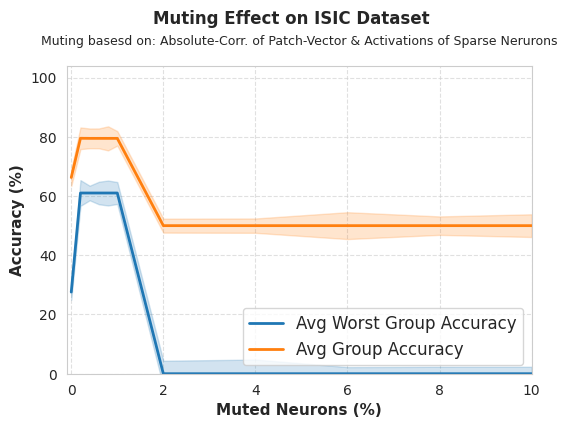

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("husl")

Avg_group_acc =  Avg_group_acc # Group accuracy values
Avg_worst_group_acc =  Avg_worst_group_acc # Worst group accuracy values

worst_group_std = np.random.uniform(2, 5, len(x))
group_acc_std = np.random.uniform(2, 5, len(x))

plt.figure(figsize=(6, 4))
plt.plot(x, Avg_worst_group_acc, color="tab:blue", label="Avg Worst Group Accuracy", linewidth=2)
plt.fill_between(x, Avg_worst_group_acc - worst_group_std, Avg_worst_group_acc + worst_group_std, 
                 color="tab:blue", alpha=0.2)

plt.plot(x, Avg_group_acc, color="tab:orange", label="Avg Group Accuracy", linewidth=2)
plt.fill_between(x, Avg_group_acc - group_acc_std, Avg_group_acc + group_acc_std, 
                 color="tab:orange", alpha=0.2)

plt.xlabel("Muted Neurons (%)", fontsize=11, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=11, fontweight="bold")
plt.title("Muting basesd on: Absolute-Corr. of Patch-Vector & Activations of Sparse Nerurons", fontsize=9, pad=15)
plt.suptitle("Muting Effect on ISIC Dataset", fontsize=12, fontweight='bold', y=1.02)
plt.xlim(-0.1, 10)
plt.ylim(0, 104)

plt.grid(True, linestyle="--", alpha=0.6)

plt.legend(fontsize=12, loc="lower right", frameon=True)
plt.show()


/tmp/ipykernel_19408/113691781.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ResNet-50-full-model-without-relu_100_epochs.pth', map_

AvgPool activations shape: (2048,)


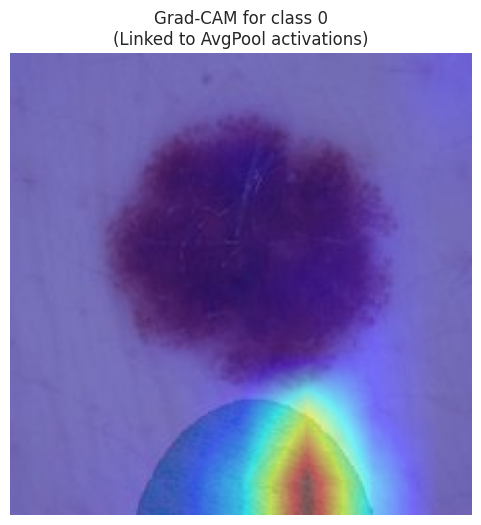

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# ------------------------------
# Load Pretrained ResNet50
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = models.resnet50(pretrained=True).to(device).eval()
model = models.resnet50(weights=None)  # Don't load pretrained weights  # Binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('ResNet-50-full-model-without-relu_100_epochs.pth', map_location=device))  # or 'cuda' if using GPU
model.eval()
model = model.to(device)
# ------------------------------
# Preprocess Image
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

img_path = "/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/B_insert_P/ISIC_0033935_2.jpg"  # replace with your image
pil_img = Image.open(img_path).convert("RGB")
input_tensor = transform(pil_img).unsqueeze(0).to(device)

rgb_img = np.array(pil_img.resize((224, 224))) / 255.0

# ------------------------------
# Capture AvgPool activations
# ------------------------------
avgpool_activations = {}
def hook_avgpool(module, input, output):
    avgpool_activations["values"] = output.detach().cpu()

hook_handle = model.avgpool.register_forward_hook(hook_avgpool)

# Run forward pass
_ = model(input_tensor)

# Extract activations (shape: [1, 2048, 1, 1])
avgpool_feats = avgpool_activations["values"].squeeze().numpy()
print("AvgPool activations shape:", avgpool_feats.shape)

hook_handle.remove()

# ------------------------------
# Grad-CAM Setup
# ------------------------------
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Use last conv block before avgpool
target_layer = model.layer4[-1]

cam = GradCAM(model=model, target_layers=[target_layer])

# Pick a class to visualize (e.g., top predicted class)
outputs = model(input_tensor)
class_id = outputs.argmax().item()
targets = [ClassifierOutputTarget(class_id)]

# Compute CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# ------------------------------
# Show Result
# ------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(cam_image)
plt.title(f"Grad-CAM for class {class_id}\n(Linked to AvgPool activations)")
plt.axis("off")
plt.show()


In [ ]:
def Encode_act(act):
    activations = act
    activations = activations.cpu().numpy()

    activations_projected = project_to_sae(sae, activations, device)
    percentage = 2
    top_neurons = load_top_neurons_from_csv(sparse_act_csv_path, percentage=percentage)
    # Muting neurons
    activations_muted = activations_projected.clone().detach()
    activations_muted[:, top_neurons] = 0
    # Decode
    activations_decoded = sae.decoder(activations_muted).to(device)
    return activations_decoded

In [ ]:
neuron_indexes = list(range(1, 2047))
print(indexes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

/tmp/ipykernel_51613/3901686715.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ResNet-50-full-model-without-relu_100_epochs.pth', map

layer4[-1] shape: torch.Size([1, 2048, 7, 7])
Predicted class: 0


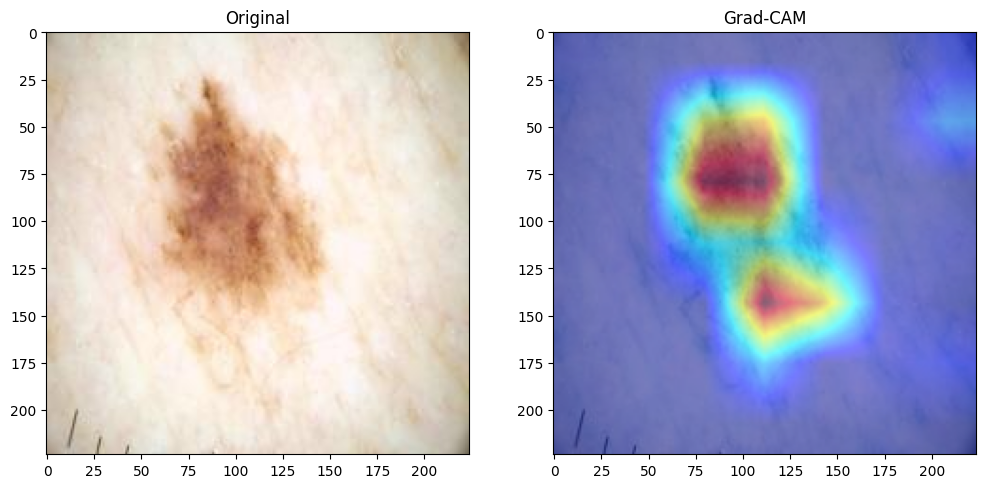

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained ResNet50
model = models.resnet50(weights=None)  # Don't load pretrained weights  # Binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('ResNet-50-full-model-without-relu_100_epochs.pth', map_location=device))  # or 'cuda' if using GPU
model.eval()
model = model.to(device)

# --------------------------
# Forward hooks to capture activations
# --------------------------
feat_maps = None
avgpool_out = None

def hook_layer4(module, input, output):
    global feat_maps
    feat_maps = output  # shape (B,2048,7,7)

def hook_avgpool(module, input, output):
    global avgpool_out
    avgpool_out = output  # shape (B,2048,1,1)

model.layer4[-1].register_forward_hook(hook_layer4)
model.avgpool.register_forward_hook(hook_avgpool)

# --------------------------
# Load sample image
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

img = Image.open("/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/isic_test/ISIC_0009898.jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# --------------------------
# Forward pass
# --------------------------
with torch.no_grad():
    _ = model(input_tensor)

print("layer4[-1] shape:", feat_maps.shape)   # (1,2048,7,7)

# --------------------------
# Expand avgpool back to 7x7 and add spatial info
# --------------------------
avgpool_out[:, neuron_indexes, :, :] = 0.0

expanded = avgpool_out.expand(-1, -1, 7, 7)  # (B,2048,7,7)
#avgpool_out = Encode_act(avgpool_out)
# Example: add some custom 7x7 spatial bias


spatial_info = torch.randn_like(expanded) * 0.05  # noise/feature maps
updated_feat_maps = feat_maps + expanded + spatial_info

# --------------------------
# Continue forward manually with updated features
# --------------------------
x = model.avgpool(updated_feat_maps)   # adaptive avg pool -> (B,2048,1,1)
x = torch.flatten(x,1)                 # flatten
output = model.fc(x)                   # classifier
pred_class = output.argmax(dim=1).item()
print("Predicted class:", pred_class)

# --------------------------
# GRAD-CAM setup on updated features
# --------------------------
gradients = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

# Attach backward hook on layer4[-1]
model.layer4[-1].register_full_backward_hook(backward_hook)

# Forward again for gradcam
output = model(input_tensor)
target_class = output.argmax(dim=1)
model.zero_grad()
output[0, target_class].backward()

# Grad-CAM calculation (FIXED)
grads = gradients.mean(dim=(2,3), keepdim=True)   # GAP over H,W
cam = (feat_maps * grads).sum(dim=1).squeeze()

# Detach before converting to numpy
cam = cam.detach().cpu().numpy()
cam = np.maximum(cam, 0)  # ReLU
cam = cv2.resize(cam, (224,224))
cam = cam / cam.max()

# Overlay on image
img_np = np.array(img.resize((224,224)))
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img_np); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(overlay[...,::-1]); plt.title("Grad-CAM")
plt.show()


In [ ]:
def encode_act(act):
    activations = act
    activations = activations.cpu().numpy()

    activations_projected = project_to_sae(sae, activations, device)
    percentage = 2
    top_neurons = load_top_neurons_from_csv(sparse_act_csv_path, percentage=percentage)
    # Muting neurons
    activations_muted = activations_projected.clone().detach()
    activations_muted[:, top_neurons] = 0
    # Decode
    activations_decoded = sae.decoder(activations_muted).to(device)
    return activations_decoded

/tmp/ipykernel_51613/1086628165.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ResNet-50-full-model-without-relu_100_epochs.pth', map

layer4[-1] shape: torch.Size([1, 2048, 7, 7])
avgpool shape: torch.Size([1, 2048, 1, 1])
Predicted class: 0


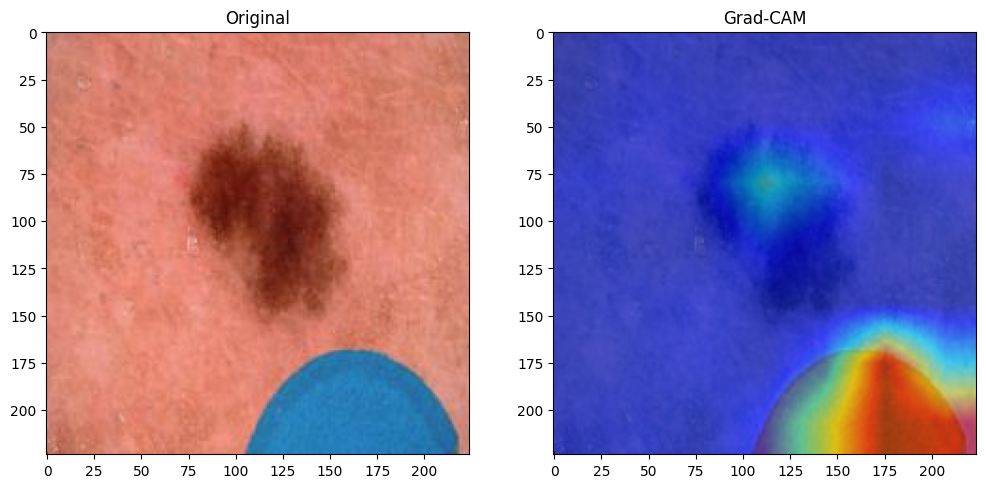

In [ ]:
# Grad_Cam
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained ResNet50
model = models.resnet50(weights=None)  # Don't load pretrained weights  # Binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('ResNet-50-full-model-without-relu_100_epochs.pth', map_location=device))  # or 'cuda' if using GPU
model.eval()
model = model.to(device)

# --------------------------
# Forward hooks to capture activations
# --------------------------
feat_maps = None
avgpool_out = None

def hook_layer4(module, input, output):
    global feat_maps
    feat_maps = output  # shape (B,2048,7,7)

def hook_avgpool(module, input, output):
    global avgpool_out
    avgpool_out = output  # shape (B,2048,1,1)

model.layer4[-1].register_forward_hook(hook_layer4)
model.avgpool.register_forward_hook(hook_avgpool)

# --------------------------
# Load sample image
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

img = Image.open("/home/ahsan/test-project/fss/ISIC/ISIC_224_Dataset/B_insert_P/ISIC_0014844_2.jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# --------------------------
# Forward pass
# --------------------------
with torch.no_grad():
    _ = model(input_tensor)

print("layer4[-1] shape:", feat_maps.shape)   # (1,2048,7,7)
print("avgpool shape:", avgpool_out.shape)    # (1,2048,1,1)

# --------------------------
# Expand avgpool back to 7x7 and add spatial info
# --------------------------
expanded = avgpool_out.expand(-1, -1, 7, 7)  # (B,2048,7,7)

# Example: add some custom 7x7 spatial bias
spatial_info = torch.randn_like(expanded) * 0.05  # noise/feature maps
updated_feat_maps = feat_maps + expanded + spatial_info

# --------------------------
# Continue forward manually with updated features
# --------------------------
x = model.avgpool(updated_feat_maps)   # adaptive avg pool -> (B,2048,1,1)
x = torch.flatten(x,1)                 # flatten
output = model.fc(x)                   # classifier
pred_class = output.argmax(dim=1).item()
print("Predicted class:", pred_class)

# --------------------------
# GRAD-CAM setup on updated features
# --------------------------
gradients = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

# Attach backward hook on layer4[-1]
model.layer4[-1].register_full_backward_hook(backward_hook)

# Forward again for gradcam
output = model(input_tensor)
target_class = output.argmax(dim=1)
model.zero_grad()
output[0, target_class].backward()

# Grad-CAM calculation (FIXED)
grads = gradients.mean(dim=(2,3), keepdim=True)   # GAP over H,W
cam = (feat_maps * grads).sum(dim=1).squeeze()

# Detach before converting to numpy
cam = cam.detach().cpu().numpy()
cam = np.maximum(cam, 0)  # ReLU
cam = cv2.resize(cam, (224,224))
cam = cam / cam.max()

# Overlay on image
img_np = np.array(img.resize((224,224)))
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img_np); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(overlay[...,::-1]); plt.title("Grad-CAM")
plt.show()


In [ ]:
# extra 1, Testing on creating correlation based on both benign and malignant labels
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = 'ResNet-50-full-model-without-relu_best_model.pth'
sae_path = 'ResNet-50-full-model-without-relu-SAE_100_epochs.pth'
sparse_act_csv_path = 'ResNet-on-ISIC_activations.csv'
Avg_group_acc = []
Avg_worst_group_acc = []
Acc_benign_core = [] 
Acc_benign_spu = [] 
Acc_malignant_core = [] 
Acc_malignant_spu = [] 
x = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 8.0, 20.0, 40.0]
# Get model and feature_extractor
model = get_model_ResNet(model_path, device)
benign_val_loader_p = ISIC_valLoader_benign_patch_200
benign_val_loader_np = ISIC_valLoader_benign_no_patch_200
malignant_val_loader_p = ISIC_valLoader_malignant_patch_200
malignant_val_loader_np = ISIC_valLoader_malignant_no_patch_200

test_benign_loader_p = ISIC_testLoader_dataset_benign_patch 
test_benign_loader_np = ISIC_testLoader_dataset_benign_no_patch 
test_malignant_loader_p = ISIC_testLoader_dataset_malignant_patch
test_malignant_loader_np = ISIC_testLoader_dataset_malignant_no_patch

# Get activations 
b_val_activations_no_patch  = get_activations_ResNet(model, benign_val_loader_np, device)
b_val_activations_patch  = get_activations_ResNet(model, benign_val_loader_p, device)

m_val_activations_no_patch  = get_activations_ResNet(model, malignant_val_loader_np, device)
m_val_activations_patch  = get_activations_ResNet(model, malignant_val_loader_p, device)

test_benign_no_patch  = get_activations_ResNet(model, test_benign_loader_np, device)
test_benign_patch  = get_activations_ResNet(model, test_benign_loader_p, device)

test_malignant_no_patch  = get_activations_ResNet(model, test_malignant_loader_np, device)
test_malignant_patch  = get_activations_ResNet(model, test_malignant_loader_p, device)

print("classify before sparse muting.....")
b_val_activations_patch_pred = classify_with_RestNet(model, b_val_activations_patch)
b_val_activations_no_patch_pred = classify_with_RestNet(model, b_val_activations_no_patch)
test_benign_patch_pred = classify_with_RestNet(model, test_benign_patch)
test_benign_no_patch_pred = classify_with_RestNet(model, test_benign_no_patch)
test_malignant_patch_pred = classify_with_RestNet(model, test_malignant_patch)
test_malignant_no_patch_pred = classify_with_RestNet(model, test_malignant_no_patch)
# Calculate group accuracy
b_val_activations_patch_acc = calculate_group_accuracy(b_val_activations_patch_pred, [0] * len(b_val_activations_patch_pred))
b_val_activations_no_patch_acc = calculate_group_accuracy(b_val_activations_no_patch_pred, [0] * len(b_val_activations_no_patch_pred))
test_benign_patch_acc = calculate_group_accuracy(test_benign_patch_pred, [0] * len(test_benign_patch_pred))
test_benign_no_patch_acc = calculate_group_accuracy(test_benign_no_patch_pred, [0] * len(test_benign_no_patch_pred))
test_malignant_patch_acc = calculate_group_accuracy(test_malignant_patch_pred, [1] * len(test_malignant_patch_pred))
test_malignant_no_patch_acc = calculate_group_accuracy(test_malignant_no_patch_pred, [1] * len(test_malignant_no_patch_pred))
print("Accuracy for Val. Benign_P(Spu): ", b_val_activations_patch_acc)
print("Accuracy for Va. Benign_NP(Core): ", b_val_activations_no_patch_acc)

print("Accuracy for Benign_NP(Core): ", test_benign_no_patch_acc)
print("Accuracy for Benign_P(Spu): ", test_benign_patch_acc)
print("Accuracy for Malignant_NP(Core): ", test_malignant_no_patch_acc)
print("Accuracy for Malignant_P(Spu): ", test_malignant_patch_acc)
print(" End of classification before sparse muting......")

# The sparse space: Project activations
sae = load_autoencoder_2(sae_path, device)
sae.to(device)
b_val_activations_patch = b_val_activations_patch.cpu().numpy()
b_val_activations_no_patch = b_val_activations_no_patch.cpu().numpy()
m_val_activations_patch = m_val_activations_patch.cpu().numpy()
m_val_activations_no_patch =  m_val_activations_no_patch.cpu().numpy()
test_benign_patch = test_benign_patch.cpu().numpy()
test_benign_no_patch = test_benign_no_patch.cpu().numpy()
test_malignant_patch = test_malignant_patch.cpu().numpy()
test_malignant_no_patch = test_malignant_no_patch.cpu().numpy()

b_projected_val_patch = project_to_sae(sae, b_val_activations_patch, device)
b_projected_val_no_patch = project_to_sae(sae, b_val_activations_no_patch, device)
m_projected_val_patch = project_to_sae(sae, m_val_activations_patch, device)
m_projected_val_no_patch = project_to_sae(sae, m_val_activations_no_patch, device)
projected_benign_test_patch = project_to_sae(sae, test_benign_patch, device)
projected_benign_test_no_patch = project_to_sae(sae, test_benign_no_patch, device)
projected_malignant_test_patch = project_to_sae(sae, test_malignant_patch, device)
projected_malignant_test_no_patch = project_to_sae(sae, test_malignant_no_patch, device)

# corr. 
correlations = activation_correlations_2(b_projected_val_patch, b_projected_val_no_patch, sparse_act_csv_path)
for percentage in x:
    # Correlaiton based Activations
    top_neurons = load_top_neurons_from_csv(sparse_act_csv_path, percentage=percentage)
    # Muting neurons
    b_projected_val_patch_muted = b_projected_val_patch.clone().detach()
    b_projected_val_no_patch_muted = b_projected_val_no_patch.clone().detach()
    projected_malignant_test_patch_muted = projected_malignant_test_patch.clone().detach()
    projected_malignant_test_no_patch_muted = projected_malignant_test_no_patch.clone().detach()
    projected_benign_test_patch_muted = projected_benign_test_patch.clone().detach()
    projected_benign_test_no_patch_muted = projected_benign_test_no_patch.clone().detach()
    b_projected_val_patch_muted[:, top_neurons] = 0
    b_projected_val_no_patch_muted[:, top_neurons] = 0
    projected_malignant_test_patch_muted[:, top_neurons] = 0
    projected_malignant_test_no_patch_muted[:, top_neurons] = 0
    projected_benign_test_patch_muted[:, top_neurons] = 0
    projected_benign_test_no_patch_muted[:, top_neurons] = 0
    # Decode
    b_decoded_val_patch = sae.decoder(b_projected_val_patch_muted).to(device)
    b_decoded_val_no_patch = sae.decoder(b_projected_val_no_patch_muted).to(device)
    decoded_malignant_test_patch = sae.decoder(projected_malignant_test_patch_muted).to(device)
    decoded_malignant_test_no_patch = sae.decoder(projected_malignant_test_no_patch_muted).to(device)
    decoded_benign_test_patch = sae.decoder(projected_benign_test_patch_muted).to(device)
    decoded_benign_test_no_patch = sae.decoder(projected_benign_test_no_patch_muted).to(device)
    # Classify
    b_predictions_val_patch_after = classify_with_RestNet(model, b_decoded_val_patch)
    b_predictions_val_no_patch_after = classify_with_RestNet(model, b_decoded_val_no_patch)
    predictions_test_malignant_patch_after = classify_with_RestNet(model, decoded_malignant_test_patch)
    predictions_test_malignant_no_patch_after = classify_with_RestNet(model, decoded_malignant_test_no_patch)
    predictions_test_benign_patch_after = classify_with_RestNet(model, decoded_benign_test_patch)
    predictions_test_benign_no_patch_after = classify_with_RestNet(model, decoded_benign_test_no_patch)
    # Calculate group accuracy
    b_accuracy_val_patch_after = calculate_group_accuracy(b_predictions_val_patch_after, [0] * len(b_predictions_val_patch_after))
    b_accuracy_val_no_patch_after = calculate_group_accuracy(b_predictions_val_no_patch_after, [0] * len(b_predictions_val_no_patch_after))
    accuracy_test_malignant_patch_after = calculate_group_accuracy(predictions_test_malignant_patch_after, [1] * len(predictions_test_malignant_patch_after))
    accuracy_test_malignant_no_patch_after = calculate_group_accuracy(predictions_test_malignant_no_patch_after, [1] * len(predictions_test_malignant_no_patch_after))
    accuracy_test_benign_patch_after = calculate_group_accuracy(predictions_test_benign_patch_after, [0] * len(predictions_test_benign_patch_after))
    accuracy_test_benign_no_patch_after = calculate_group_accuracy(predictions_test_benign_no_patch_after, [0] * len(predictions_test_benign_no_patch_after))
    # Worst and average group accuracies
    AGA = (accuracy_test_malignant_patch_after + accuracy_test_malignant_no_patch_after + accuracy_test_benign_patch_after + accuracy_test_benign_no_patch_after) / 4
    AWGA = min(accuracy_test_malignant_patch_after, accuracy_test_malignant_no_patch_after, accuracy_test_benign_patch_after, accuracy_test_benign_no_patch_after)
    Avg_group_acc.append(AGA)
    Avg_worst_group_acc.append(AWGA)
    Acc_benign_core.append(accuracy_test_benign_no_patch_after)
    Acc_benign_spu.append(accuracy_test_benign_patch_after)
    Acc_malignant_core.append(accuracy_test_malignant_no_patch_after)
    Acc_malignant_spu.append(accuracy_test_malignant_patch_after)
    # Rounded values
    Avg_group_acc_rv = [round(x * 100, 2) for x in Avg_group_acc]
    Avg_worst_group_acc_rv = [round(x * 100, 2) for x in Avg_worst_group_acc]
    Acc_benign_core_rv = [round(x * 100, 2) for x in Acc_benign_core]
    Acc_benign_spu_rv = [round(x * 100, 2) for x in Acc_benign_spu]
    Acc_malignant_core_rv = [round(x * 100, 2) for x in Acc_malignant_core]
    Acc_malignant_spu_rv = [round(x * 100, 2) for x in Acc_malignant_spu]
    print("Muting percentage x = ", percentage)
print("*" * 50)
print("We apply muting percentage: x = ", x)
print(f"Avg_group_acc: {Avg_group_acc_rv}")
print(f"Avg_worst_group_acc: {Avg_worst_group_acc_rv}")  
print(f"Acc_benign_core: {Acc_benign_core_rv}")
print(f"Acc_benign_spu: {Acc_benign_spu_rv}")
print(f"Acc_malignant_core: {Acc_malignant_core_rv}")
print(f"Acc_malignant_spu: {Acc_malignant_spu_rv}")

    #print("Prediction and Evaluation All Groups:")
    #prediction_and_evaluation(model, val_all_activations_decoded, val_loader, b_val_labels_all)
print("*" * 50)
print("Evalutaion Complete!")


classify before sparse muting.....
Accuracy for Val. Benign_P(Spu):  1.0
Accuracy for Va. Benign_NP(Core):  0.755
Accuracy for Benign_NP(Core):  0.7127929069031033
Accuracy for Benign_P(Spu):  0.998914223669924
Accuracy for Malignant_NP(Core):  0.7493917274939172
Accuracy for Malignant_P(Spu):  0.2850182704019488
 End of classification before sparse muting......
Muting percentage x =  0
Muting percentage x =  0.1
Muting percentage x =  0.2
Muting percentage x =  0.3
Muting percentage x =  0.4
Muting percentage x =  0.5
Muting percentage x =  0.6
Muting percentage x =  0.7
Muting percentage x =  0.8
Muting percentage x =  0.9
Muting percentage x =  5
Muting percentage x =  10
Muting percentage x =  20
Muting percentage x =  40
**************************************************
We apply muting percentage: x =  [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 5, 10, 20, 40]
Avg_group_acc: [66.31, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23]
Av

In [ ]:
"""  2-val-subgroups for act_corr.                      25-val """
We apply muting percentage: x =  [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 5, 10, 20, 40]
Avg_group_acc: [66.31, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23]
Avg_worst_group_acc: [23.02, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34]
Acc_benign_core: [73.4, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37]
Acc_benign_spu: [99.96, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35]
Acc_malignant_core: [68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86]
Acc_malignant_spu: [23.02, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34]
**************************************************
"""                                                     50-val """
We apply muting percentage: x =  [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 5, 10, 20, 40]
Avg_group_acc: [66.31, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23]
Avg_worst_group_acc: [23.02, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34]
Acc_benign_core: [73.4, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37]
Acc_benign_spu: [99.96, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35]
Acc_malignant_core: [68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86]
Acc_malignant_spu: [23.02, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34]
**************************************************
"""                                                     100-val """
We apply muting percentage: x =  [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 5, 10, 20, 40]
Avg_group_acc: [66.31, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23]
Avg_worst_group_acc: [23.02, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34]
Acc_benign_core: [73.4, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37]
Acc_benign_spu: [99.96, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35]
Acc_malignant_core: [68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86]
Acc_malignant_spu: [23.02, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34]
**************************************************
"""                                                     200-val """
We apply muting percentage: x =  [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 5, 10, 20, 40]
Avg_group_acc: [66.31, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23, 76.23]
Avg_worst_group_acc: [23.02, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34]
Acc_benign_core: [73.4, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37, 73.37]
Acc_benign_spu: [99.96, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35, 99.35]
Acc_malignant_core: [68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86, 68.86]
Acc_malignant_spu: [23.02, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34, 63.34]
**************************************************

In [ ]:
act_values = test_malignant_no_patch
print(act_values.shape)
print(type(act_values))
print(act_values.size)
total_zeros = np.count_nonzero(act_values == 0)
print("total zero in act_values", total_zeros)
total_non_zeros = np.count_nonzero(act_values)
print("total non-zero in act_values", total_non_zeros)
print("Percentage of zeros:", (np.count_nonzero(act_values == 0) / act_values.size) * 100)
print("act_values", act_values)

(822, 4096)
<class 'numpy.ndarray'>
3366912
total zero in act_values 0
total non-zero in act_values 3366912
Percentage of zeros: 0.0
act_values [[-10.916729  -10.235258   -1.1100008 ...  -8.735856   -7.943118
   -5.628887 ]
 [ -4.4484468  -5.8034244  -2.5513158 ...  -7.6842937  -6.550909
   -1.7748637]
 [-13.325357  -11.698982   -3.3402324 ... -11.012579   -6.124813
  -11.34589  ]
 ...
 [ -5.616117   -4.299453   -1.1419663 ...  -4.5508747 -10.085447
   -7.1382065]
 [ -3.002611  -12.216394   -7.0951724 ...  -3.7902834  -9.496363
   -5.188573 ]
 [ -5.461441   -6.6915298  -2.7333348 ...  -6.3294992  -6.194792
   -3.8171728]]


In [ ]:
act_values = projected_malignant_test_patch.cpu().numpy()
print(act_values.shape)
print(type(act_values))
print(act_values.size)
total_zeros = np.count_nonzero(act_values == 0)
print("total zero in act_values", total_zeros)
total_non_zeros = np.count_nonzero(act_values)
print("total non-zero in act_values", total_non_zeros)
print("Percentage of zeros:", (np.count_nonzero(act_values == 0) / act_values.size) * 100)
print("act_values", act_values)

(821, 8000)
<class 'numpy.ndarray'>
6568000
total zero in act_values 6481380
total non-zero in act_values 86620
Percentage of zeros: 98.6811814859927
act_values [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
"""Evaluating original ResNet-50 model on ISIC test dataset..."""
Accuracy for Benign_NoPatches: 0.7372
Accuracy for Benign_Patches: 0.9996
Accuracy for Malignant_NoPatches: 0.8601
Accuracy for Malignant_Patches: 0.5104

SyntaxError: invalid syntax (3142337445.py, line 2)

In [ ]:
# extra 1, Testing on creating correlation based on both benign and malignant labels
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_path = '/home/ahsan/test-project/fss/split-metadata/testing-resNet-model/ResNet-results-without-relu/AlexNet-full-model/AlexNet_full_model_on_ISIC/AlexNet-full-model-without-relu_best_model.pth'
sae_path = '/home/ahsan/test-project/fss/split-metadata/testing-resNet-model/ResNet-results-without-relu/AlexNet-full-model/AlexNet_full_model_on_ISIC/AlexNet-full-model-without-relu-SAE_100_epochs.pth'
sparse_act_csv_path = '/home/ahsan/test-project/fss/split-metadata/testing-resNet-model/ResNet-results-without-relu/AlexNet-full-model/AlexNet_full_model_on_ISIC/AlexNet-on-ISIC_activations.csv'
Avg_group_acc = []
Avg_worst_group_acc = []
Acc_benign_core = [] 
Acc_benign_spu = [] 
Acc_malignant_core = [] 
Acc_malignant_spu = [] 
x = [0, 0.1, 0.2, 0.4, 0.8, 1.0, 1.5, 2]
val_loader_name = "ISIC_testLoader_dataset_benign"
# Get model and feature_extractor
model = get_model(model_path, device)

benign_val_loader_p = ISIC_valLoader_benign_patch_200
benign_val_loader_np = ISIC_valLoader_benign_no_patch_200
malignant_val_loader_p = ISIC_valLoader_malignant_patch_200
malignant_val_loader_np = ISIC_valLoader_malignant_no_patch_200 
test_benign_loader_p = ISIC_testLoader_dataset_benign_patch 
test_benign_loader_np = ISIC_testLoader_dataset_benign_no_patch 
test_malignant_loader_p = ISIC_testLoader_dataset_malignant_patch
test_malignant_loader_np = ISIC_testLoader_dataset_malignant_no_patch

# Get activations 
b_val_activations_no_patch  = get_activations_AlexNet(model, benign_val_loader_np, device)
b_val_activations_patch  = get_activations_AlexNet(model, benign_val_loader_p, device)

m_val_activations_no_patch  = get_activations_AlexNet(model, malignant_val_loader_np, device)
m_val_activations_patch  = get_activations_AlexNet(model, malignant_val_loader_p, device)

test_benign_no_patch  = get_activations_AlexNet(model, test_benign_loader_np, device)
test_benign_patch  = get_activations_AlexNet(model, test_benign_loader_p, device)

test_malignant_no_patch  = get_activations_AlexNet(model, test_malignant_loader_np, device)
test_malignant_patch  = get_activations_AlexNet(model, test_malignant_loader_p, device)

print("classify before sparse muting.....")
b_val_activations_patch_pred = classify_with_AlexNet(model, b_val_activations_patch)
b_val_activations_no_patch_pred = classify_with_AlexNet(model, b_val_activations_no_patch)
test_benign_patch_pred = classify_with_AlexNet(model, test_benign_patch)
test_benign_no_patch_pred = classify_with_AlexNet(model, test_benign_no_patch)
test_malignant_patch_pred = classify_with_AlexNet(model, test_malignant_patch)
test_malignant_no_patch_pred = classify_with_AlexNet(model, test_malignant_no_patch)
# Calculate group accuracy
b_val_activations_patch_acc = calculate_group_accuracy(b_val_activations_patch_pred, [0] * len(b_val_activations_patch_pred))
b_val_activations_no_patch_acc = calculate_group_accuracy(b_val_activations_no_patch_pred, [0] * len(b_val_activations_no_patch_pred))
test_benign_patch_acc = calculate_group_accuracy(test_benign_patch_pred, [0] * len(test_benign_patch_pred))
test_benign_no_patch_acc = calculate_group_accuracy(test_benign_no_patch_pred, [0] * len(test_benign_no_patch_pred))
test_malignant_patch_acc = calculate_group_accuracy(test_malignant_patch_pred, [1] * len(test_malignant_patch_pred))
test_malignant_no_patch_acc = calculate_group_accuracy(test_malignant_no_patch_pred, [1] * len(test_malignant_no_patch_pred))
print("Accuracy for Val. Benign_P(Spu): ", b_val_activations_patch_acc)
print("Accuracy for Va. Benign_NP(Core): ", b_val_activations_no_patch_acc)

print("Accuracy for Benign_NP(Core): ", test_benign_no_patch_acc)
print("Accuracy for Benign_P(Spu): ", test_benign_patch_acc)
print("Accuracy for Malignant_NP(Core): ", test_malignant_no_patch_acc)
print("Accuracy for Malignant_P(Spu): ", test_malignant_patch_acc)
print(" End of classify before sparse muting......")
# The sparse space: Project activations
sae = load_autoencoder_2(sae_path, device)
sae.to(device)
b_val_activations_patch = b_val_activations_patch.cpu().numpy()
b_val_activations_no_patch = b_val_activations_no_patch.cpu().numpy()
m_val_activations_patch = m_val_activations_patch.cpu().numpy()
m_val_activations_no_patch =  m_val_activations_no_patch.cpu().numpy()
test_benign_patch = test_benign_patch.cpu().numpy()
test_benign_no_patch = test_benign_no_patch.cpu().numpy()
test_malignant_patch = test_malignant_patch.cpu().numpy()
test_malignant_no_patch = test_malignant_no_patch.cpu().numpy()
"""
b_projected_val_patch = project_to_sae(sae, b_val_activations_patch, device)
b_projected_val_no_patch = project_to_sae(sae, b_val_activations_no_patch, device)
m_projected_val_patch = project_to_sae(sae, m_val_activations_patch, device)
m_projected_val_no_patch = project_to_sae(sae, m_val_activations_no_patch, device)
projected_benign_test_patch = project_to_sae(sae, test_benign_patch, device)
projected_benign_test_no_patch = project_to_sae(sae, test_benign_no_patch, device)
projected_malignant_test_patch = project_to_sae(sae, test_malignant_patch, device)
projected_malignant_test_no_patch = project_to_sae(sae, test_malignant_no_patch, device)
"""
b_projected_val_patch = sae.encoder(torch.from_numpy(b_val_activations_patch).float().to(device))
b_projected_val_no_patch = sae.encoder(torch.from_numpy(b_val_activations_no_patch).float().to(device))
m_projected_val_patch = sae.encoder(torch.from_numpy(m_val_activations_patch).float().to(device))
m_projected_val_no_patch = sae.encoder(torch.from_numpy(m_val_activations_no_patch).float().to(device))
projected_benign_test_patch = sae.encoder(torch.from_numpy(test_benign_patch).float().to(device))
projected_benign_test_no_patch = sae.encoder(torch.from_numpy(test_benign_no_patch).float().to(device))
projected_malignant_test_patch = sae.encoder(torch.from_numpy(test_malignant_patch).float().to(device))
projected_malignant_test_no_patch = sae.encoder(torch.from_numpy(test_malignant_no_patch).float().to(device))

# corr. 
correlations = activation_correlations_2(b_projected_val_patch, b_projected_val_no_patch, sparse_act_csv_path)
for percentage in x:
    # Correlaiton based Activations
    top_neurons = load_top_neurons_from_csv(sparse_act_csv_path, percentage=percentage)
    # Muting neurons
    b_projected_val_patch_muted = b_projected_val_patch.clone().detach() # tensors do not have .copy(), exists for NumPy arrays only.
    b_projected_val_no_patch_muted = b_projected_val_no_patch.clone().detach() # tensors do not have .copy(), exists for NumPy arrays only.
    projected_malignant_test_patch_muted = projected_malignant_test_patch.clone().detach()
    projected_malignant_test_no_patch_muted = projected_malignant_test_no_patch.clone().detach()
    projected_benign_test_patch_muted = projected_benign_test_patch.clone().detach()
    projected_benign_test_no_patch_muted = projected_benign_test_no_patch.clone().detach()
    b_projected_val_patch_muted[:, top_neurons] = 0
    b_projected_val_no_patch_muted[:, top_neurons] = 0
    projected_malignant_test_patch_muted[:, top_neurons] = 0
    projected_malignant_test_no_patch_muted[:, top_neurons] = 0
    projected_benign_test_patch_muted[:, top_neurons] = 0
    projected_benign_test_no_patch_muted[:, top_neurons] = 0
    # Decode
    b_decoded_val_patch = sae.decoder(b_projected_val_patch_muted).to(device)
    b_decoded_val_no_patch = sae.decoder(b_projected_val_no_patch_muted).to(device)
    decoded_malignant_test_patch = sae.decoder(projected_malignant_test_patch_muted).to(device)
    decoded_malignant_test_no_patch = sae.decoder(projected_malignant_test_no_patch_muted).to(device)
    decoded_benign_test_patch = sae.decoder(projected_benign_test_patch_muted).to(device)
    decoded_benign_test_no_patch = sae.decoder(projected_benign_test_no_patch_muted).to(device)
    # Classify
    b_predictions_val_patch_after = classify_with_AlexNet(model, b_decoded_val_patch)
    b_predictions_val_no_patch_after = classify_with_AlexNet(model, b_decoded_val_no_patch)
    predictions_test_malignant_patch_after = classify_with_AlexNet(model, decoded_malignant_test_patch)
    predictions_test_malignant_no_patch_after = classify_with_AlexNet(model, decoded_malignant_test_no_patch)
    predictions_test_benign_patch_after = classify_with_AlexNet(model, decoded_benign_test_patch)
    predictions_test_benign_no_patch_after = classify_with_AlexNet(model, decoded_benign_test_no_patch)
    # Calculate group accuracy
    b_accuracy_val_patch_after = calculate_group_accuracy(b_predictions_val_patch_after, [0] * len(b_predictions_val_patch_after))
    b_accuracy_val_no_patch_after = calculate_group_accuracy(b_predictions_val_no_patch_after, [0] * len(b_predictions_val_no_patch_after))
    accuracy_test_malignant_patch_after = calculate_group_accuracy(predictions_test_malignant_patch_after, [1] * len(predictions_test_malignant_patch_after))
    accuracy_test_malignant_no_patch_after = calculate_group_accuracy(predictions_test_malignant_no_patch_after, [1] * len(predictions_test_malignant_no_patch_after))
    accuracy_test_benign_patch_after = calculate_group_accuracy(predictions_test_benign_patch_after, [0] * len(predictions_test_benign_patch_after))
    accuracy_test_benign_no_patch_after = calculate_group_accuracy(predictions_test_benign_no_patch_after, [0] * len(predictions_test_benign_no_patch_after))
    # Worst and average group accuracies
    AGA = (accuracy_test_malignant_patch_after + accuracy_test_malignant_no_patch_after + accuracy_test_benign_patch_after + accuracy_test_benign_no_patch_after) / 4
    AWGA = min(accuracy_test_malignant_patch_after, accuracy_test_malignant_no_patch_after, accuracy_test_benign_patch_after, accuracy_test_benign_no_patch_after)
    Avg_group_acc.append(AGA)
    Avg_worst_group_acc.append(AWGA)
    Acc_benign_core.append(accuracy_test_benign_no_patch_after)
    Acc_benign_spu.append(accuracy_test_benign_patch_after)
    Acc_malignant_core.append(accuracy_test_malignant_no_patch_after)
    Acc_malignant_spu.append(accuracy_test_malignant_patch_after)
    # Rounded values
    Avg_group_acc_rv = [round(x * 100, 2) for x in Avg_group_acc]
    Avg_worst_group_acc_rv = [round(x * 100, 2) for x in Avg_worst_group_acc]
    Acc_benign_core_rv = [round(x * 100, 2) for x in Acc_benign_core]
    Acc_benign_spu_rv = [round(x * 100, 2) for x in Acc_benign_spu]
    Acc_malignant_core_rv = [round(x * 100, 2) for x in Acc_malignant_core]
    Acc_malignant_spu_rv = [round(x * 100, 2) for x in Acc_malignant_spu]
    print("Muting percentage x = ", percentage)
print("*" * 50)
print("We apply muting percentage: x = ", x)
print(f"Avg_group_acc: {Avg_group_acc_rv}")
print(f"Avg_worst_group_acc: {Avg_worst_group_acc_rv}")  
print(f"Acc_benign_core: {Acc_benign_core_rv}")
print(f"Acc_benign_spu: {Acc_benign_spu_rv}")
print(f"Acc_malignant_core: {Acc_malignant_core_rv}")
print(f"Acc_malignant_spu: {Acc_malignant_spu_rv}")

    #print("Prediction and Evaluation All Groups:")
    #prediction_and_evaluation(model, val_all_activations_decoded, val_loader, b_val_labels_all)
print("*" * 50)
print("Evalutaion Complete!")


classify before sparse muting.....
Accuracy for Val. Benign_P(Spu):  1.0
Accuracy for Va. Benign_NP(Core):  0.87
Accuracy for Benign_NP(Core):  0.8125395820139328
Accuracy for Benign_P(Spu):  1.0
Accuracy for Malignant_NP(Core):  0.7141119221411192
Accuracy for Malignant_P(Spu):  0.2095006090133983
 End of classify before sparse muting......
Muting percentage x =  0
Muting percentage x =  0.1
Muting percentage x =  0.2
Muting percentage x =  0.4
Muting percentage x =  0.8
Muting percentage x =  1.0
Muting percentage x =  1.5
Muting percentage x =  2
**************************************************
We apply muting percentage: x =  [0, 0.1, 0.2, 0.4, 0.8, 1.0, 1.5, 2]
Avg_group_acc: [68.77, 72.16, 70.49, 64.13, 61.06, 61.06, 61.06, 61.06]
Avg_worst_group_acc: [24.73, 52.25, 52.74, 40.8, 34.1, 34.1, 34.1, 34.1]
Acc_benign_core: [77.14, 82.84, 84.58, 87.9, 87.78, 87.78, 87.78, 87.78]
Acc_benign_spu: [100.0, 92.62, 88.06, 79.77, 80.75, 80.75, 80.75, 80.75]
Acc_malignant_core: [73.24, 60.9

In [ ]:
# set variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/home/ahsan/test-project/fss/split-metadata/testing-resNet-model/ResNet-results-without-relu/AlexNet-full-model/AlexNet_full_model_on_ISIC/AlexNet-full-model-without-relu_best_model.pth'
sae_path = '/home/ahsan/test-project/fss/split-metadata/testing-resNet-model/ResNet-results-without-relu/AlexNet-full-model/AlexNet_full_model_on_ISIC/AlexNet-full-model-without-relu-SAE_100_epochs.pth'
sparse_act_csv_path = '/home/ahsan/test-project/fss/split-metadata/testing-resNet-model/ResNet-results-without-relu/AlexNet-full-model/AlexNet_full_model_on_ISIC/AlexNet-on-ISIC_activations.csv'
#org_act_csv_path = '/run/determined/workdir/CNN_Exp/SC-Mitigation/trained-models/neuron_csv_files/ISIC_neuron_correlation_validation_activations_all_testset_original_act_abs.csv'
Avg_group_acc = [] 
Avg_worst_group_acc = []
Acc_benign_core = [] 
Acc_benign_spu = [] 
Acc_malignant_core = [] 
Acc_malignant_spu = [] 
x = [0, 1, 2, 4, 8, 20, 40, 60]
val_loader_name = "ISIC_testLoader_dataset_benign" # 
benign_val_loader = ISIC_valLoader_benign_no_yes_patch_200 #ISIC_val_benign #ISIC_val_loader # ISIC_valLoader_benign_no_yes_patch_25
test_benign_loader =  ISIC_testLoader_dataset_benign #ISIC_testLoader_benign_no_yes_100 #ISIC_testLoader_dataset_benign
test_malignant_loader =  ISIC_testLoader_dataset_malignant #ISIC_testLoader_malignant_no_yes_100 #ISIC_testLoader_dataset_malignant
# Get model and feature_extractor
model, feature_extractor = get_model_and_feature_extractor2(model_path, device)
# Get activations
b_val_activations_no_patch, b_val_labels_all, b_val_activations_patch, b_val_labels_spu = get_activations_2(model, feature_extractor, benign_val_loader)
test_benign_no_patch, test_benign_labels_all, test_benign_patch, test_benign_labels_spu = get_activations_2(model, feature_extractor, test_benign_loader)
test_malignant_no_patch, test_malignant_labels_all, test_malignant_patch, test_malignant_labels_spu = get_activations_2(model, feature_extractor, test_malignant_loader)

b_val_activations_patch = b_val_activations_patch.cpu().numpy()
b_val_activations_no_patch = b_val_activations_no_patch.cpu().numpy()
test_benign_patch = test_benign_patch.cpu().numpy()
test_benign_no_patch = test_benign_no_patch.cpu().numpy()
test_malignant_patch = test_malignant_patch.cpu().numpy()
test_malignant_no_patch = test_malignant_no_patch.cpu().numpy()
# sparse projections
sae = load_autoencoder_2(sae_path, device)
sae.to(device)
projected_val_patch = project_to_sae(sae, b_val_activations_patch, device)
projected_val_no_patch = project_to_sae(sae, b_val_activations_no_patch, device)
projected_benign_test_patch = project_to_sae(sae, test_benign_patch, device)
projected_benign_test_no_patch = project_to_sae(sae, test_benign_no_patch, device)
projected_malignant_test_patch = project_to_sae(sae, test_malignant_patch, device)
projected_malignant_test_no_patch = project_to_sae(sae, test_malignant_no_patch, device)

#projected_val_patch = projected_val_patch.to(device)
#projected_val_no_patch = projected_val_no_patch.to(device)
#projected_malignant_test_patch = projected_malignant_test_patch.to(device)
#projected_malignant_test_no_patch = projected_malignant_test_no_patch.to(device)
#projected_benign_test_patch = projected_benign_test_patch.to(device)
#projected_benign_test_no_patch = projected_benign_test_no_patch.to(device)

correlations = activation_correlations_2(projected_val_patch, projected_val_no_patch, sparse_act_csv_path)    
for percentage in x:    
    # Correlaiton based Activations
    top_neurons = load_top_neurons_from_csv(sparse_act_csv_path, percentage=percentage)
    # Muting neurons
    projected_val_patch_muted = projected_val_patch.clone().detach() # tensors do not have .copy(), exists for NumPy arrays only.
    projected_val_no_patch_muted = projected_val_no_patch.clone().detach() # tensors do not have .copy(), exists for NumPy arrays only.
    projected_malignant_test_patch_muted = projected_malignant_test_patch.clone().detach()
    projected_malignant_test_no_patch_muted = projected_malignant_test_no_patch.clone().detach()
    projected_benign_test_patch_muted = projected_benign_test_patch.clone().detach()
    projected_benign_test_no_patch_muted = projected_benign_test_no_patch.clone().detach()
    projected_val_patch_muted[:, top_neurons] = 0
    projected_val_no_patch_muted[:, top_neurons] = 0
    projected_malignant_test_patch_muted[:, top_neurons] = 0
    projected_malignant_test_no_patch_muted[:, top_neurons] = 0
    projected_benign_test_patch_muted[:, top_neurons] = 0
    projected_benign_test_no_patch_muted[:, top_neurons] = 0
    # Decode
    decoded_val_patch = sae.decoder(projected_val_patch_muted).to(device)
    decoded_val_no_patch = sae.decoder(projected_val_no_patch_muted).to(device)
    decoded_malignant_test_patch = sae.decoder(projected_malignant_test_patch_muted).to(device)
    decoded_malignant_test_no_patch = sae.decoder(projected_malignant_test_no_patch_muted).to(device)
    decoded_benign_test_patch = sae.decoder(projected_benign_test_patch_muted).to(device)
    decoded_benign_test_no_patch = sae.decoder(projected_benign_test_no_patch_muted).to(device)
    # Classify
    predictions_val_patch_after = classify_with_AlexNet(model, decoded_val_patch)
    predictions_val_no_patch_after = classify_with_AlexNet(model, decoded_val_no_patch)
    predictions_test_malignant_patch_after = classify_with_AlexNet(model, decoded_malignant_test_patch)
    predictions_test_malignant_no_patch_after = classify_with_AlexNet(model, decoded_malignant_test_no_patch)
    predictions_test_benign_patch_after = classify_with_AlexNet(model, decoded_benign_test_patch)
    predictions_test_benign_no_patch_after = classify_with_AlexNet(model, decoded_benign_test_no_patch)
    # Calculate group accuracy
    accuracy_val_patch_after = calculate_group_accuracy(predictions_val_patch_after, [0] * len(predictions_val_patch_after))
    accuracy_val_no_patch_after = calculate_group_accuracy(predictions_val_no_patch_after, [0] * len(predictions_val_no_patch_after))
    accuracy_test_malignant_patch_after = calculate_group_accuracy(predictions_test_malignant_patch_after, [1] * len(predictions_test_malignant_patch_after))
    accuracy_test_malignant_no_patch_after = calculate_group_accuracy(predictions_test_malignant_no_patch_after, [1] * len(predictions_test_malignant_no_patch_after))
    accuracy_test_benign_patch_after = calculate_group_accuracy(predictions_test_benign_patch_after, [0] * len(predictions_test_benign_patch_after))
    accuracy_test_benign_no_patch_after = calculate_group_accuracy(predictions_test_benign_no_patch_after, [0] * len(predictions_test_benign_no_patch_after))
    # Worst and average group accuracies
    AGA = (accuracy_test_malignant_patch_after + accuracy_test_malignant_no_patch_after + accuracy_test_benign_patch_after + accuracy_test_benign_no_patch_after) / 4
    AWGA = min(accuracy_test_malignant_patch_after, accuracy_test_malignant_no_patch_after, accuracy_test_benign_patch_after, accuracy_test_benign_no_patch_after)
    Avg_group_acc.append(AGA)
    Avg_worst_group_acc.append(AWGA)
    Acc_benign_core.append(accuracy_test_benign_no_patch_after)
    Acc_benign_spu.append(accuracy_test_benign_patch_after)
    Acc_malignant_core.append(accuracy_test_malignant_no_patch_after)
    Acc_malignant_spu.append(accuracy_test_malignant_patch_after)
    # Rounded values
    Avg_group_acc_rv = [round(x * 100, 2) for x in Avg_group_acc]
    Avg_worst_group_acc_rv = [round(x * 100, 2) for x in Avg_worst_group_acc]
    Acc_benign_core_rv = [round(x * 100, 2) for x in Acc_benign_core]
    Acc_benign_spu_rv = [round(x * 100, 2) for x in Acc_benign_spu]
    Acc_malignant_core_rv = [round(x * 100, 2) for x in Acc_malignant_core]
    Acc_malignant_spu_rv = [round(x * 100, 2) for x in Acc_malignant_spu]
    print("Muting percentage x = ", percentage)
    
print("*" * 50)
print("We apply ISIC_val_benign for corr. analysis and muting percentage = ", x)
print(f"Avg_group_acc: {Avg_group_acc_rv}")
print(f"Avg_worst_group_acc: {Avg_worst_group_acc_rv}")  
print(f"Acc_benign_core: {Acc_benign_core_rv}")
print(f"Acc_benign_spu: {Acc_benign_spu_rv}")
print(f"Acc_malignant_core: {Acc_malignant_core_rv}")
print(f"Acc_malignant_spu: {Acc_malignant_spu_rv}")

    #print("Prediction and Evaluation All Groups:")
    #prediction_and_evaluation(model, val_all_activations_decoded, val_loader, b_val_labels_all)
print("*" * 50)
print("Evalutaion Complete!")


TypeError: get_activations_2() missing 1 required positional argument: 'val_loader_name'

In [ ]:
# extra 1 old method
def main():
    # set variables
    #device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    banign_act_csv_path = '/home/ahsan/test-project/fss/trained-models/neuron_csv_files/ISIC_neuron_correlation_benign_25_testing_combined.csv'
    malignant_act_csv_path = '/home/ahsan/test-project/fss/trained-models/neuron_csv_files/ISIC_neuron_correlation_malignant_25_testing_combined.csv'
    model_path = '/home/ahsan/test-project/fss/split-metadata/testing-resNet-model/ResNet-results-without-relu/AlexNet-full-model/AlexNet_full_model_on_ISIC/AlexNet-full-model-without-relu_best_model.pth'
    sae_path = '/home/ahsan/test-project/fss/split-metadata/testing-resNet-model/ResNet-results-without-relu/AlexNet-full-model/AlexNet_full_model_on_ISIC/AlexNet-full-model-without-relu-SAE_100_epochs.pth'
    act_csv_path = '/home/ahsan/test-project/fss/split-metadata/testing-resNet-model/ResNet-results-without-relu/AlexNet-full-model/AlexNet_full_model_on_ISIC/AlexNet-on-ISIC_activations.csv'
    print("#" * 50)
    Avg_group_acc = []
    Avg_worst_group_acc = []
    Acc_benign_core = [] 
    Acc_benign_spu = [] 
    Acc_malignant_core = [] 
    Acc_malignant_spu = [] 
    #x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40]  # Muted Neurons percentage
    x = [0, 0.1, 0.2, 0.4, 0.8, 1.0, 1.5, 2]
    # Get model and feature_extractor
    model  = get_model(model_path, device)
    #define_dataloaders
    benign_val_loader_p = ISIC_valLoader_benign_patch_200
    benign_val_loader_np = ISIC_valLoader_benign_no_patch_200
    malignant_val_loader_p = ISIC_valLoader_malignant_patch_200
    malignant_val_loader_np = ISIC_valLoader_malignant_no_patch_200 
    test_benign_loader_p = ISIC_testLoader_dataset_benign_patch 
    test_benign_loader_np = ISIC_testLoader_dataset_benign_no_patch 
    test_malignant_loader_p = ISIC_testLoader_dataset_malignant_patch
    test_malignant_loader_np = ISIC_testLoader_dataset_malignant_no_patch
    # Get_activations 
    b_val_activations_no_patch  = get_activations_AlexNet(model, benign_val_loader_np, device)
    b_val_activations_patch  = get_activations_AlexNet(model, benign_val_loader_p, device)

    m_val_activations_no_patch  = get_activations_AlexNet(model, malignant_val_loader_np, device)
    m_val_activations_patch  = get_activations_AlexNet(model, malignant_val_loader_p, device)

    test_benign_no_patch  = get_activations_AlexNet(model, test_benign_loader_np, device)
    test_benign_patch  = get_activations_AlexNet(model, test_benign_loader_p, device)

    test_malignant_no_patch  = get_activations_AlexNet(model, test_malignant_loader_np, device)
    test_malignant_patch  = get_activations_AlexNet(model, test_malignant_loader_p, device)
    
    b_val_activations_no_patch = b_val_activations_no_patch.cpu().numpy()
    b_val_activations_patch = b_val_activations_patch.cpu().numpy()
    
    b_test_benign_no_patch = test_benign_no_patch.cpu().numpy()
    b_test_benign_patch = test_benign_patch.cpu().numpy()
    m_test_malignant_no_patch = test_malignant_no_patch.cpu().numpy()
    m_test_malignant_patch = test_malignant_patch.cpu().numpy()
    # The sparse space: Project val_activations
    sae = load_autoencoder_2(sae_path, device)
    sae = sae.to(device)
    b_all_activations_projected = project_to_sae(sae, b_val_activations_no_patch, device)
    b_spu_activations_projected = project_to_sae(sae, b_val_activations_patch, device)
    b_test_benign_no_patch_projected = project_to_sae(sae, b_test_benign_no_patch, device)
    b_test_benign_patch_projected = project_to_sae(sae, b_test_benign_patch, device)
    m_test_malignant_no_patch_projected = project_to_sae(sae, m_test_malignant_no_patch, device)
    m_test_malignant_patch_projected = project_to_sae(sae, m_test_malignant_patch, device)
    
    correlations = activation_correlations_2(b_all_activations_projected, b_spu_activations_projected, banign_act_csv_path)
    for percentage in x:
        # Correlaiton based Activations
        top_neurons = load_top_neurons_from_csv(banign_act_csv_path, percentage=percentage)
        b_all_activations_muted = b_all_activations_projected.clone().detach()
        b_spu_activations_muted = b_spu_activations_projected.clone().detach()
        b_test_benign_no_patch_muted = b_test_benign_no_patch_projected.clone().detach()
        b_test_benign_patch_muted = b_test_benign_patch_projected.clone().detach()
        m_test_malignant_no_patch_muted = m_test_malignant_no_patch_projected.clone().detach()
        m_test_malignant_patch_muted = m_test_malignant_patch_projected.clone().detach()
        #val_all_activations_muted = val_all_activations_projected.copy()
        b_all_activations_muted[:, top_neurons] = 0
        b_spu_activations_muted[:, top_neurons] = 0
        b_test_benign_no_patch_muted[:, top_neurons] = 0
        b_test_benign_patch_muted[:, top_neurons] = 0
        m_test_malignant_no_patch_muted[:, top_neurons] = 0
        m_test_malignant_patch_muted[:, top_neurons] = 0        
        # The sparse space: Decode and classify
        b_all_activations_decoded = sae.decoder(b_all_activations_muted).to(device)
        b_spu_all_activations_decoded = sae.decoder(b_spu_activations_muted).to(device)
        b_test_benign_no_patch_decoded = sae.decoder(b_test_benign_no_patch_muted).to(device)
        b_test_benign_patch_decoded = sae.decoder(b_test_benign_patch_muted).to(device)
        m_test_malignant_no_patch_decoded = sae.decoder(m_test_malignant_no_patch_muted).to(device)
        m_test_malignant_patch_decoded = sae.decoder(m_test_malignant_patch_muted).to(device)
        #classify
        b_predictions_after_muting_core = classify_with_AlexNet(model, b_all_activations_decoded)
        b_predictions_after_muting_spu = classify_with_AlexNet(model, b_spu_all_activations_decoded)
        b_test_benign_no_patch_core = classify_with_AlexNet(model, b_test_benign_no_patch_decoded)
        b_test_benign_patch_spu = classify_with_AlexNet(model, b_test_benign_patch_decoded)
        m_test_malignant_no_patch_core = classify_with_AlexNet(model, m_test_malignant_no_patch_decoded)
        m_test_malignant_patch_spu = classify_with_AlexNet(model, m_test_malignant_patch_decoded)
        #group_accuracy
        accuracy_after_muting_benign_core = calculate_group_accuracy(b_predictions_after_muting_core, [0] * len(b_predictions_after_muting_core))
        accuracy_after_muting_benign_spu = calculate_group_accuracy(b_predictions_after_muting_spu, [0] * len(b_predictions_after_muting_spu))
        accuracy_after_muting_benign_test_core = calculate_group_accuracy(b_test_benign_no_patch_core, [0] * len(b_test_benign_no_patch_core))
        accuracy_after_muting_benign_test_spu = calculate_group_accuracy(b_test_benign_patch_spu, [0] * len(b_test_benign_patch_spu))
        accuracy_after_muting_malignant_test_core = calculate_group_accuracy(m_test_malignant_no_patch_core, [1] * len(m_test_malignant_no_patch_core))
        accuracy_after_muting_malignant_test_spu = calculate_group_accuracy(m_test_malignant_patch_spu, [1] * len(m_test_malignant_patch_spu))
        
        AGA = (accuracy_after_muting_malignant_test_core + accuracy_after_muting_malignant_test_spu + accuracy_after_muting_benign_test_core + accuracy_after_muting_benign_test_spu)/4
        AWGA = min(accuracy_after_muting_malignant_test_core, accuracy_after_muting_malignant_test_spu, accuracy_after_muting_benign_test_core, accuracy_after_muting_benign_test_spu)
        Avg_group_acc.append(AGA)
        Avg_worst_group_acc.append(AWGA)
        Acc_benign_core.append(accuracy_after_muting_benign_test_core)
        Acc_benign_spu.append(accuracy_after_muting_benign_test_spu)
        Acc_malignant_core.append(accuracy_after_muting_malignant_test_core)
        Acc_malignant_spu.append(accuracy_after_muting_malignant_test_spu)
        # Rounded values
        Avg_group_acc_rv = [round(x * 100, 2) for x in Avg_group_acc]
        Avg_worst_group_acc_rv = [round(x * 100, 2) for x in Avg_worst_group_acc]
        Acc_benign_core_rv = [round(x * 100, 2) for x in Acc_benign_core]
        Acc_benign_spu_rv = [round(x * 100, 2) for x in Acc_benign_spu]
        Acc_malignant_core_rv = [round(x * 100, 2) for x in Acc_malignant_core]
        Acc_malignant_spu_rv = [round(x * 100, 2) for x in Acc_malignant_spu]
    print("x = ", x)
    print(f"Avg_group_acc: {Avg_group_acc_rv}")
    print(f"Avg_worst_group_acc: {Avg_worst_group_acc_rv}")  
    print(f"Acc_benign_core: {Acc_benign_core_rv}")
    print(f"Acc_benign_spu: {Acc_benign_spu_rv}")
    print(f"Acc_malignant_core: {Acc_malignant_core_rv}")
    print(f"Acc_malignant_spu: {Acc_malignant_spu_rv}")
    
    print("*" * 50)
    print("Evalutaion Complete!")
if __name__ == "__main__":
    main()
    

##################################################
x =  [0, 0.1, 0.2, 0.4, 0.8, 1.0, 1.5, 2]
Avg_group_acc: [68.77, 57.25, 53.13, 50.06, 50.03, 50.0, 50.0, 50.0]
Avg_worst_group_acc: [24.73, 6.46, 1.1, 0.0, 0.0, 0.0, 0.0, 0.0]
Acc_benign_core: [77.14, 88.95, 96.23, 100.0, 100.0, 100.0, 100.0, 100.0]
Acc_benign_spu: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Acc_malignant_core: [73.24, 33.58, 15.21, 0.24, 0.12, 0.0, 0.0, 0.0]
Acc_malignant_spu: [24.73, 6.46, 1.1, 0.0, 0.0, 0.0, 0.0, 0.0]
**************************************************
Evalutaion Complete!


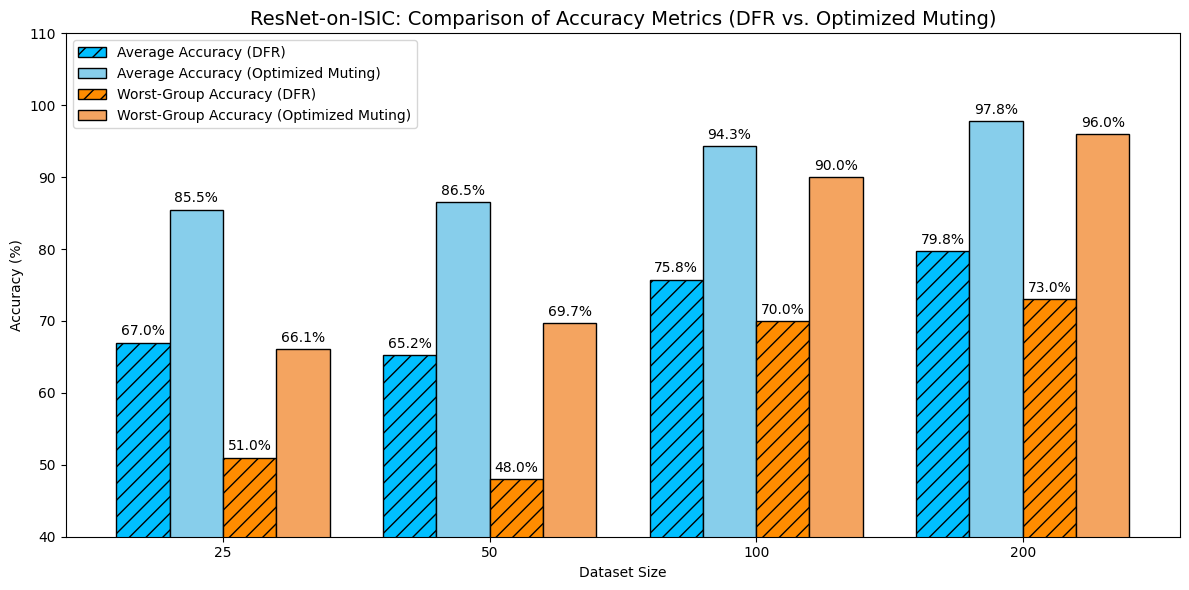

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset sizes
dataset_sizes = [25, 50, 100, 200]
x = np.arange(len(dataset_sizes))  # X-axis positions
width = 0.2  # Width of bars

# Accuracy values (replace with your actual values)
avg_acc_dfr = [67.0, 65.25, 75.75, 79.75]
avg_acc_muted = [85.5, 86.50,  94.33, 97.75]
worst_group_dfr = [51.0, 48.0, 70.0, 73.0]
worst_group_muted = [66.08, 69.66, 90.0, 96.0]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Bars
bar1 = ax.bar(x - 1.5*width, avg_acc_dfr, width, label='Average Accuracy (DFR)', hatch='//', color='deepskyblue', edgecolor='black')
bar2 = ax.bar(x - 0.5*width, avg_acc_muted, width, label='Average Accuracy (Optimized Muting)', color='skyblue', edgecolor='black')
bar3 = ax.bar(x + 0.5*width, worst_group_dfr, width, label='Worst-Group Accuracy (DFR)', hatch='//', color='darkorange', edgecolor='black')
bar4 = ax.bar(x + 1.5*width, worst_group_muted, width, label='Worst-Group Accuracy (Optimized Muting)', color='sandybrown', edgecolor='black')

# Labels and title
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Dataset Size')
ax.set_title('ResNet-on-ISIC: Comparison of Accuracy Metrics (DFR vs. Optimized Muting)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(dataset_sizes)
ax.set_ylim(40, 110)
ax.legend()

# Value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("husl")

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40]  # Muted Neurons (%)

Avg_group_acc =  Avg_group_acc # Group accuracy values
Avg_worst_group_acc =  Avg_worst_group_acc # Worst group accuracy values

worst_group_std = np.random.uniform(2, 5, len(x))
group_acc_std = np.random.uniform(2, 5, len(x))

plt.figure(figsize=(8, 5))
plt.plot(x, Avg_worst_group_acc, color="tab:blue", label="Avg Worst Group Accuracy", linewidth=2)
plt.fill_between(x, Avg_worst_group_acc - worst_group_std, Avg_worst_group_acc + worst_group_std, 
                 color="tab:blue", alpha=0.2)

plt.plot(x, Avg_group_acc, color="tab:orange", label="Avg Group Accuracy", linewidth=2)
plt.fill_between(x, Avg_group_acc - group_acc_std, Avg_group_acc + group_acc_std, 
                 color="tab:orange", alpha=0.2)

plt.xlabel("Muted Neurons (%)", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=14, fontweight="bold")
plt.title("Patch-Vector Corr. Effect of 200 Validation Images", fontsize=12, pad=15)
plt.suptitle("Muting Effect on WB Dataset (5684 - Test Images)", fontsize=14, fontweight='bold', y=1.02)
plt.xlim(-3, 44)
plt.ylim(20, 108)

plt.grid(True, linestyle="--", alpha=0.6)

plt.legend(fontsize=12, loc="lower right", frameon=True)
plt.show()


In [ ]:
Dataset::  ISIC - Validation
" x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 60]  # Muted Neurons percentage" 

" images 25 "
Avg_group_acc
[50, 72, 76, 76, 77, 77, 77, 77, 77, 74, 74, 74, 74, 74]
Avg_worst_group_acc
[24, 40, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]

" images 50 "
Avg_group_acc
[48, 66, 78, 78, 78, 78, 79, 79, 79, 79, 79, 78, 78, 78]
Avg_worst_group_acc
[26, 24, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]

" images 100 "
Avg_group_acc
[50, 70, 79, 79, 79, 79, 80, 80, 81, 82, 82, 81, 81, 81]
Avg_worst_group_acc
[24, 48, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]

" images 200 "
Avg_group_acc
[50, 73, 79, 79, 79, 79, 80, 80, 81, 82, 82, 81, 81, 81]
Avg_worst_group_acc
[24, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("husl")

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 60]  # Muted Neurons (%)

Avg_group_acc = [82, 88, 90, 90, 93, 93, 94, 94, 94, 95, 95, 95, 95, 95]  # Group accuracy values
Avg_worst_group_acc_WB = [57, 76, 78, 77, 84, 84, 86, 86, 86, 87, 87, 87, 87, 87]  # Worst group accuracy values

worst_group_std = np.random.uniform(2, 5, len(x))
group_acc_std = np.random.uniform(2, 5, len(x))

plt.figure(figsize=(8, 5))
plt.plot(x, Avg_worst_group_acc_WB, color="tab:blue", label="Avg Worst Group Accuracy", linewidth=2)
plt.fill_between(x, Avg_worst_group_acc_WB - worst_group_std, Avg_worst_group_acc_WB + worst_group_std, 
                 color="tab:blue", alpha=0.2)

plt.plot(x, Avg_group_acc, color="tab:orange", label="Avg Group Accuracy", linewidth=2)
plt.fill_between(x, Avg_group_acc - group_acc_std, Avg_group_acc + group_acc_std, 
                 color="tab:orange", alpha=0.2)

plt.xlabel("Muted Neurons (%)", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=14, fontweight="bold")
plt.title("Muting Effect on WaterBird Dataset (200 Images)- Validation Accuracy", fontsize=14, pad=15)

plt.xlim(-3, 44)
plt.ylim(20, 108)

plt.grid(True, linestyle="--", alpha=0.6)

plt.legend(fontsize=12, loc="lower right", frameon=True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Muted Neuron Percentages
x_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 60]
x = np.arange(len(x_labels))  # the label locations
bar_width = 0.2

# Data
group_acc = {
    "25": [71, 79, 87, 89, 89, 89, 92, 89, 90, 90, 90, 90, 90, 90],
    "50": [78, 84, 87, 90, 92, 91, 92, 94, 93, 94, 94, 94, 94, 94],
    "100": [80, 87, 89, 90, 91, 92, 92, 92, 92, 93, 93, 93, 93, 93]
    }

worst_acc = {
    "25": [40, 60, 76, 80, 80, 80, 84, 72, 76, 76, 76, 76, 76, 76],
    "50": [54, 70, 76, 80, 84, 84, 86, 86, 84, 88, 88, 88, 88, 88],
    "100": [56, 75, 78, 77, 78, 78, 79, 79, 80, 82, 82, 82, 82, 82]
    }

fig, axs = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Avg Group Accuracy
for i, (label, values) in enumerate(group_acc.items()):
    axs[0].bar(x + i * bar_width, values, width=bar_width, label=f'Images {label}')

axs[0].set_ylabel('Avg Group Accuracy (%)')
axs[0].set_title('Avg Group Accuracy vs Muted Neurons')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

# Avg Worst Group Accuracy
for i, (label, values) in enumerate(worst_acc.items()):
    axs[1].bar(x + i * bar_width, values, width=bar_width, label=f'Images {label}')

axs[1].set_ylabel('Avg Worst Group Accuracy (%)')
axs[1].set_title('Avg Worst Group Accuracy vs Muted Neurons')
axs[1].set_xticks(x + 1.5 * bar_width)
axs[1].set_xticklabels(x_labels)
axs[1].set_xlabel('Muted Neurons (%)')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set(style="whitegrid")
colors = sns.color_palette("husl", 2)

# X-axis (e.g., steps, muted neurons, etc.)
x = list(range(len([50, 72, 76, 76, 77, 77, 77, 77, 77, 74, 74, 74, 74, 74])))

# All datasets
datasets = {
    "Images: 25": {
        "Avg_group_acc": [50, 72, 76, 76, 77, 77, 77, 77, 77, 74, 74, 74, 74, 74],
        "Avg_worst_group_acc": [24, 40, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]
    },
    "Images: 50": {
        "Avg_group_acc": [48, 66, 78, 78, 78, 78, 79, 79, 79, 79, 79, 78, 78, 78],
        "Avg_worst_group_acc": [26, 24, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
    },
    "Images: 100": {
        "Avg_group_acc": [50, 70, 79, 79, 79, 79, 80, 80, 81, 82, 82, 81, 81, 81],
        "Avg_worst_group_acc": [24, 48, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    },
    "Images: 200": {
        "Avg_group_acc": [50, 73, 79, 79, 79, 79, 80, 80, 81, 82, 82, 81, 81, 81],
        "Avg_worst_group_acc": [24, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    }
}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

bar_width = 0.35

for idx, (title, data) in enumerate(datasets.items()):
    ax = axes[idx]
    x_pos = np.arange(len(data["Avg_group_acc"]))

    # Bars
    ax.bar(x_pos - bar_width/2, data["Avg_group_acc"], bar_width, label="Avg Group Acc", color=colors[0])
    ax.bar(x_pos + bar_width/2, data["Avg_worst_group_acc"], bar_width, label="Avg Worst Group Acc", color=colors[1])

    # Aesthetics
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Step", fontsize=12)
    ax.set_ylabel("Accuracy (%)", fontsize=12)
    ax.set_ylim(0, 100)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Group vs Worst Group Accuracy Across Different Image Counts", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


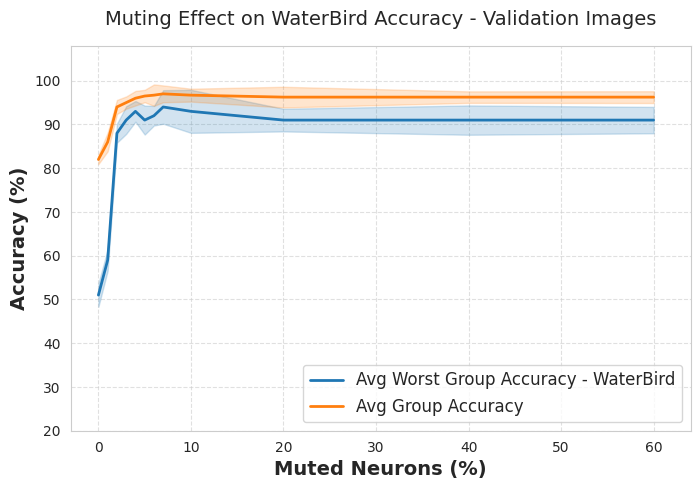

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Enable Seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# 🔹 Generate synthetic data (replace with your real data)
x = [0, 1, 2, 3, 4, 5, 6, 7, 10, 20, 40, 60]  # Muted Neurons (%)

Avg_group_acc =          [82, 86, 94, 95, 96, 96.5, 96.7, 97, 96.7, 96.25, 96.25, 96.25 ]  # Group accuracy values
Avg_worst_group_acc_WB = [51, 59, 88, 91, 93, 91, 92, 94, 93, 91, 91, 91]  # Worst group accuracy values
# 🔹 Compute confidence intervals (shaded region)
worst_group_std = np.random.uniform(2, 5, len(x))
group_acc_std = np.random.uniform(1, 3, len(x))

# 🔹 Plot with confidence intervals
plt.figure(figsize=(8, 5))
plt.plot(x, Avg_worst_group_acc_WB, color="tab:blue", label="Avg Worst Group Accuracy - WaterBird", linewidth=2)
plt.fill_between(x, Avg_worst_group_acc_WB - worst_group_std, Avg_worst_group_acc_WB + worst_group_std, 
                 color="tab:blue", alpha=0.2)

plt.plot(x, Avg_group_acc, color="tab:orange", label="Avg Group Accuracy", linewidth=2)
plt.fill_between(x, Avg_group_acc - group_acc_std, Avg_group_acc + group_acc_std, 
                 color="tab:orange", alpha=0.2)

# 🔹 Labels and title
plt.xlabel("Muted Neurons (%)", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=14, fontweight="bold")
plt.title("Muting Effect on WaterBird Accuracy - Validation Images", fontsize=14, pad=15)

# 🔹 Set axis limits for better visibility
plt.xlim(-3, 64)
plt.ylim(20, 108)

# 🔹 Customize grid
plt.grid(True, linestyle="--", alpha=0.6)

# 🔹 Add a legend
plt.legend(fontsize=12, loc="lower right", frameon=True)

# 🔹 Display the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Enable Seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# 🔹 Generate synthetic data (replace with your real data)
x = [0, 1, 2, 3, 4, 5, 6, 7, 10, 20, 40, 60]  # Muted Neurons (%)

Avg_group_acc =          [82, 86, 94, 95, 96, 96.5, 96.7, 97, 96.7, 96.25, 96.25, 96.25 ]  # Group accuracy values
Avg_worst_group_acc_LB = [81, 86, 90, 93, 93, 95, 95, 95, 95, 95, 95, 95]  # Worst group accuracy values
# 🔹 Compute confidence intervals (shaded region)
worst_group_std = np.random.uniform(2, 5, len(x))
group_acc_std = np.random.uniform(1, 3, len(x))

# 🔹 Plot with confidence intervals
plt.figure(figsize=(8, 5))
plt.plot(x, avg_worst_group_acc_LB, color="tab:blue", label="Avg Worst Group Accuracy - LandBird", linewidth=2)
plt.fill_between(x, Avg_worst_group_acc_LB - worst_group_std, Avg_worst_group_acc_LB + worst_group_std, 
                 color="tab:blue", alpha=0.2)

plt.plot(x, Avg_group_acc, color="tab:orange", label="Avg Group Accuracy", linewidth=2)
plt.fill_between(x, Avg_group_acc - group_acc_std, Avg_group_acc + group_acc_std, 
                 color="tab:orange", alpha=0.2)

# 🔹 Labels and title
plt.xlabel("Muted Neurons (%)", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=14, fontweight="bold")
plt.title("Muting Effect on LandBird Accuracy - Validation Images", fontsize=14, pad=15)

# 🔹 Set axis limits for better visibility
plt.xlim(-3, 64)
plt.ylim(20, 108)

# 🔹 Customize grid
plt.grid(True, linestyle="--", alpha=0.6)

# 🔹 Add a legend
plt.legend(fontsize=12, loc="lower right", frameon=True)

# 🔹 Display the plot
plt.show()


NameError: name 'avg_worst_group_acc_LB' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
# at 50% pruning
Accuracy for Waterbird_Land: 0.71
Accuracy for Waterbird_Water: 0.99
# at 20% pruning
Accuracy for Waterbird_Land: 0.71
Accuracy for Waterbird_Water: 0.99
# at 15% pruning
Accuracy for Waterbird_Land: 0.71
Accuracy for Waterbird_Water: 0.99
# at 10% pruning
Accuracy for Waterbird_Land: 0.57
Accuracy for Waterbird_Water: 0.99
# at 7% pruning
Accuracy for Waterbird_Land: 0.54
Accuracy for Waterbird_Water: 0.99
# at 5% pruning
Accuracy for Waterbird_Land: 0.48
Accuracy for Waterbird_Water: 0.97
# at 3% pruning
Accuracy for Waterbird_Land: 0.41
Accuracy for Waterbird_Water: 0.97
# at 2% pruning
Accuracy for Waterbird_Land: 0.38
Accuracy for Waterbird_Water: 0.96
# at 1% pruning
Accuracy for Waterbird_Land: 0.33
Accuracy for Waterbird_Water: 0.96
# at 0% pruning
accuracy_before_muting_WB_spu:  0.51
accuracy_before_muting_WB_core: 0.99

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define epochs and class accuracies
epochs = [0.0, 1, 2, 3, 4, 5, 10, 20, 50, 80]
class_accuracies = {
    "Waterbird (Land)": [0.54, 0.55, 0.63, 0.67, 0.70, 0.72, 0.66, 0.56, 0.47, 0.41],
    "Waterbird (Water)": [0.96, 0.50, 0.74, 0.85, 0.90, 0.93, 0.89, 0.91, 0.92, 0.94]
}

# Set seaborn style for a clean look
sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(14,5))

# Iterate through each class and plot with different line styles
linestyles = ['-', '--', '-.', ':']  # Different styles for differentiation
for (class_name, acc), linestyle in zip(class_accuracies.items(), linestyles):
    plt.plot(epochs, acc, marker='o', linestyle=linestyle, linewidth=2, markersize=6, label=class_name)

plt.xticks(epochs)
# Titles and labels
plt.xlabel("Pruning Threshold", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.ylim(0.3, 1)  # Keep a minimum y-limit for better visibility
plt.title("Accuracy Over Time for Each Class", fontsize=14, fontweight='bold')

# Grid and legend
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Class Type", fontsize=10, title_fontsize=12, loc="lower right")

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define epochs and class accuracies
epochs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
class_accuracies = {
    "Landbird (Land)": [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.98, 0.98, 0.98, 0.97, 0.93, 0.77],
    "Landbird (Water)": [0.81, 0.90, 0.92, 0.93,  0.93, 0.92, 0.91, 0.90, 0.85, 0.77, 0.67, 0.44],
    "Waterbird (Land)": [0.54, 0.55, 0.57, 0.58, 0.60, 0.62, 0.64, 0.69, 0.72, 0.79, 0.88, 0.97],
    "Waterbird (Water)": [0.99, 0.96, 0.96, 0.94, 0.94, 0.95, 0.96, 0.98, 0.98, 0.99, 0.99, 1.00]
}

# Set seaborn style for a clean look
sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(14,5))

# Iterate through each class and plot with different line styles
linestyles = ['-', '--', '-.', ':']  # Different styles for differentiation
for (class_name, acc), linestyle in zip(class_accuracies.items(), linestyles):
    plt.plot(epochs, acc, marker='o', linestyle=linestyle, linewidth=2, markersize=6, label=class_name)

plt.xticks(epochs)
# Titles and labels
plt.xlabel("Pruning Threshold", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.ylim(0.3, 1)  # Keep a minimum y-limit for better visibility
plt.title("Accuracy Over Time for Each Class", fontsize=14, fontweight='bold')

# Grid and legend
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Class Type", fontsize=10, title_fontsize=12, loc="lower right")

# Show the plot
plt.show()

In [ ]:
import numpy as np

# Example accuracy over epochs
epochs = np.arange(1, 11)
class_accuracies = {
    "Class 0": [0.6, 0.65, 0.7, 0.75, 0.8, 0.82, 0.84, 0.85, 0.86, 0.87],
    "Class 1": [0.5, 0.6, 0.7, 0.78, 0.85, 0.87, 0.88, 0.89, 0.9, 0.91],
    "Class 2": [0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.72, 0.74, 0.75, 0.76],
    "Class 3": [0.55, 0.6, 0.65, 0.7, 0.75, 0.78, 0.79, 0.8, 0.82, 0.83]
}

# Create stylish line plot
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

for class_name, acc in class_accuracies.items():
    sns.lineplot(x=epochs, y=acc, marker='o', label=class_name)

# Labels and title
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy Over Epochs for Each Class", fontsize=14)
plt.legend(title="Classes")

plt.show()


In [ ]:
import numpy as np
from scipy.stats import pearsonr

# Example activations for two sets of neurons
A = np.array([0.1, 0.4, 0.5, 0.6])
B = np.array([0.15, 0.38, 0.52, 0.58])

# Calculate Pearson correlation coefficient
correlation_coefficient, _ = pearsonr(A, B)
print(f"Correlation Coefficient: {correlation_coefficient}")

# Example correlation matrix for a set of neurons
activations = np.array([
    [0.1, 0.4, 0.5, 0.6],
    [0.15, 0.38, 0.52, 0.58],
    [0.2, 0.3, 0.4, 0.5],
    [0.12, 0.35, 0.48, 0.55]
])

# Compute correlation matrix
correlation_matrix = np.corrcoef(activations)
print("Correlation Matrix:")
print(correlation_matrix)

# Identify highly correlated neurons (e.g., threshold > 0.9)
threshold = 0.9
highly_correlated = np.where(np.abs(correlation_matrix) > threshold)
print("Highly Correlated Neuron Pairs:", highly_correlated)
for i, j in zip(*highly_correlated):
    if i != j:  # Avoid diagonal elements
        print(f"Neuron {i} and Neuron {j}")